In [317]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [318]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [24]:
train_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'train.csv')
sub_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜(집을 판매한 날짜)
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수(.5는 화장실은 있으나 샤워실은 없는 방)
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도(0~4)
11. condition : 집의 전반적인 상태(1~5)
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
* 1부터13의 지수, 여기서 1,2,3은 건물 구조 및 설계에 미달하고, 7은 평균 수준의 구조 및 설계이며, 11,12,13은 고품질 수준의 구조 및 설계를 나타냅니다.
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 해당 주택을 기준으로 주변 15개 주택의 주거 공간 평균 면적
21. sqft_lot15 : 주변 15개 주택의 부지 면적 평균

In [25]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [26]:
y = data['price']

del data['price']

In [27]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [323]:
data.shape

(21503, 20)

In [324]:
y.shape

(15035,)

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

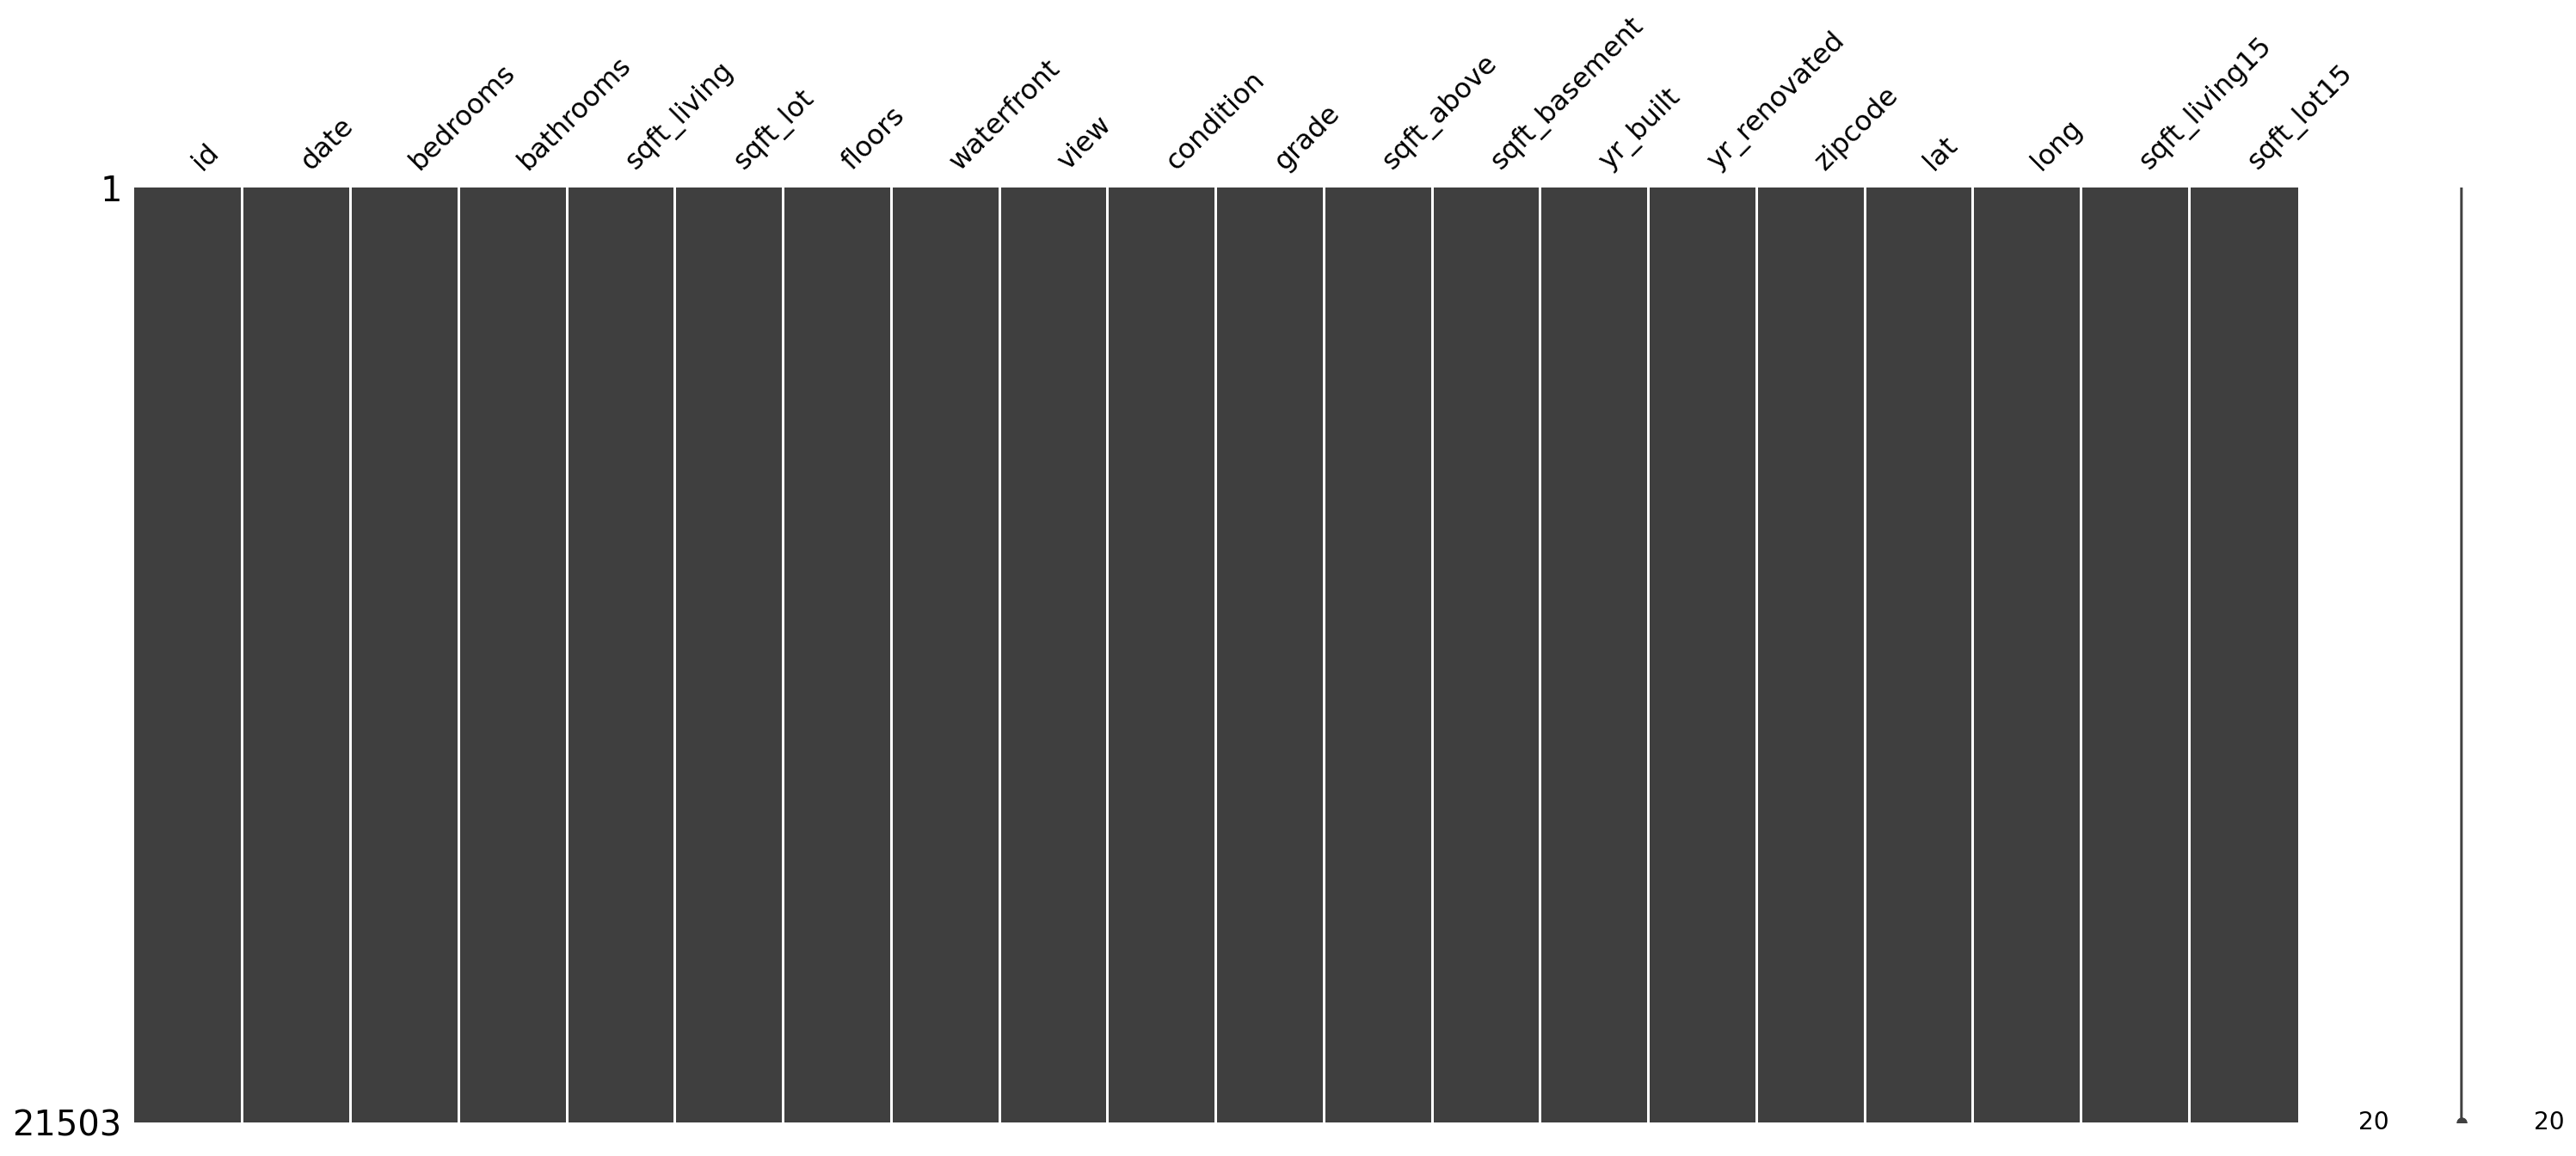

In [325]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [326]:
data.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [28]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

In [328]:
data['date']

0       201410
1       201502
2       201502
3       201406
4       201501
         ...  
6463    201406
6464    201501
6465    201502
6466    201406
6467    201501
Name: date, Length: 21503, dtype: object

In [329]:
data['date'] = data['date'].astype('int64')

In [330]:
data.reset_index(drop=True,inplace=True)

In [331]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m')

In [332]:
data['date']

0       2014-10-01
1       2015-02-01
2       2015-02-01
3       2014-06-01
4       2015-01-01
           ...    
21498   2014-06-01
21499   2015-01-01
21500   2015-02-01
21501   2014-06-01
21502   2015-01-01
Name: date, Length: 21503, dtype: datetime64[ns]

<AxesSubplot:xlabel='date', ylabel='price'>

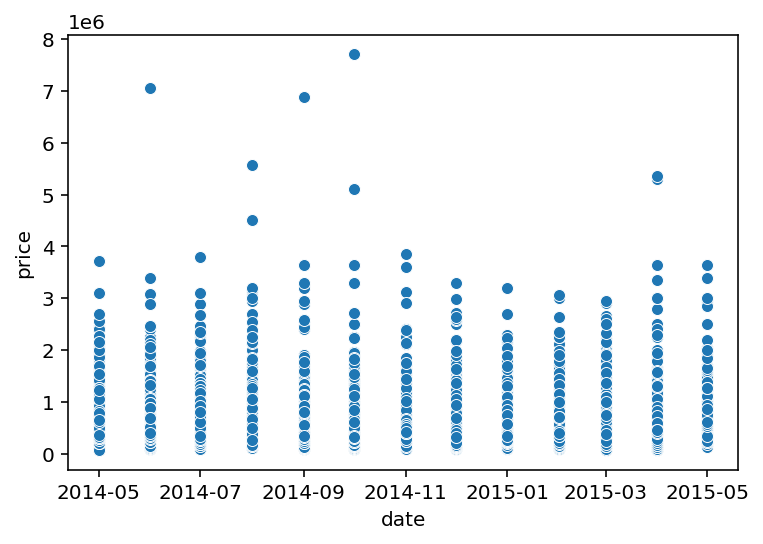

In [333]:
sns.scatterplot(data['date'],y)

In [334]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data = data.drop(columns=['date'])

In [335]:
data.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       1.00         1180      5650     1.0           0     0   
1         2       1.00          770     10000     1.0           0     0   
2         3       2.00         1680      8080     1.0           0     0   
3         3       2.25         1715      6819     2.0           0     0   
4         3       1.50         1060      9711     1.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7        1180              0      1955             0   
1          3      6         770              0      1933             0   
2          3      8        1680              0      1987             0   
3          3      7        1715              0      1995             0   
4          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  year  month  
0    98178  47.5112 -122.257           1340        5650  2014     10  
1    98028  47.7379 -122.233           2720        8062  2015      2  
2    98074  47.6168 -122.045           1800        7503  2015      2  
3    98003  47.3097 -122.327           2238        6819  2014      6  
4    98198  47.4095 -122.315           1650        9711  2015      1

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

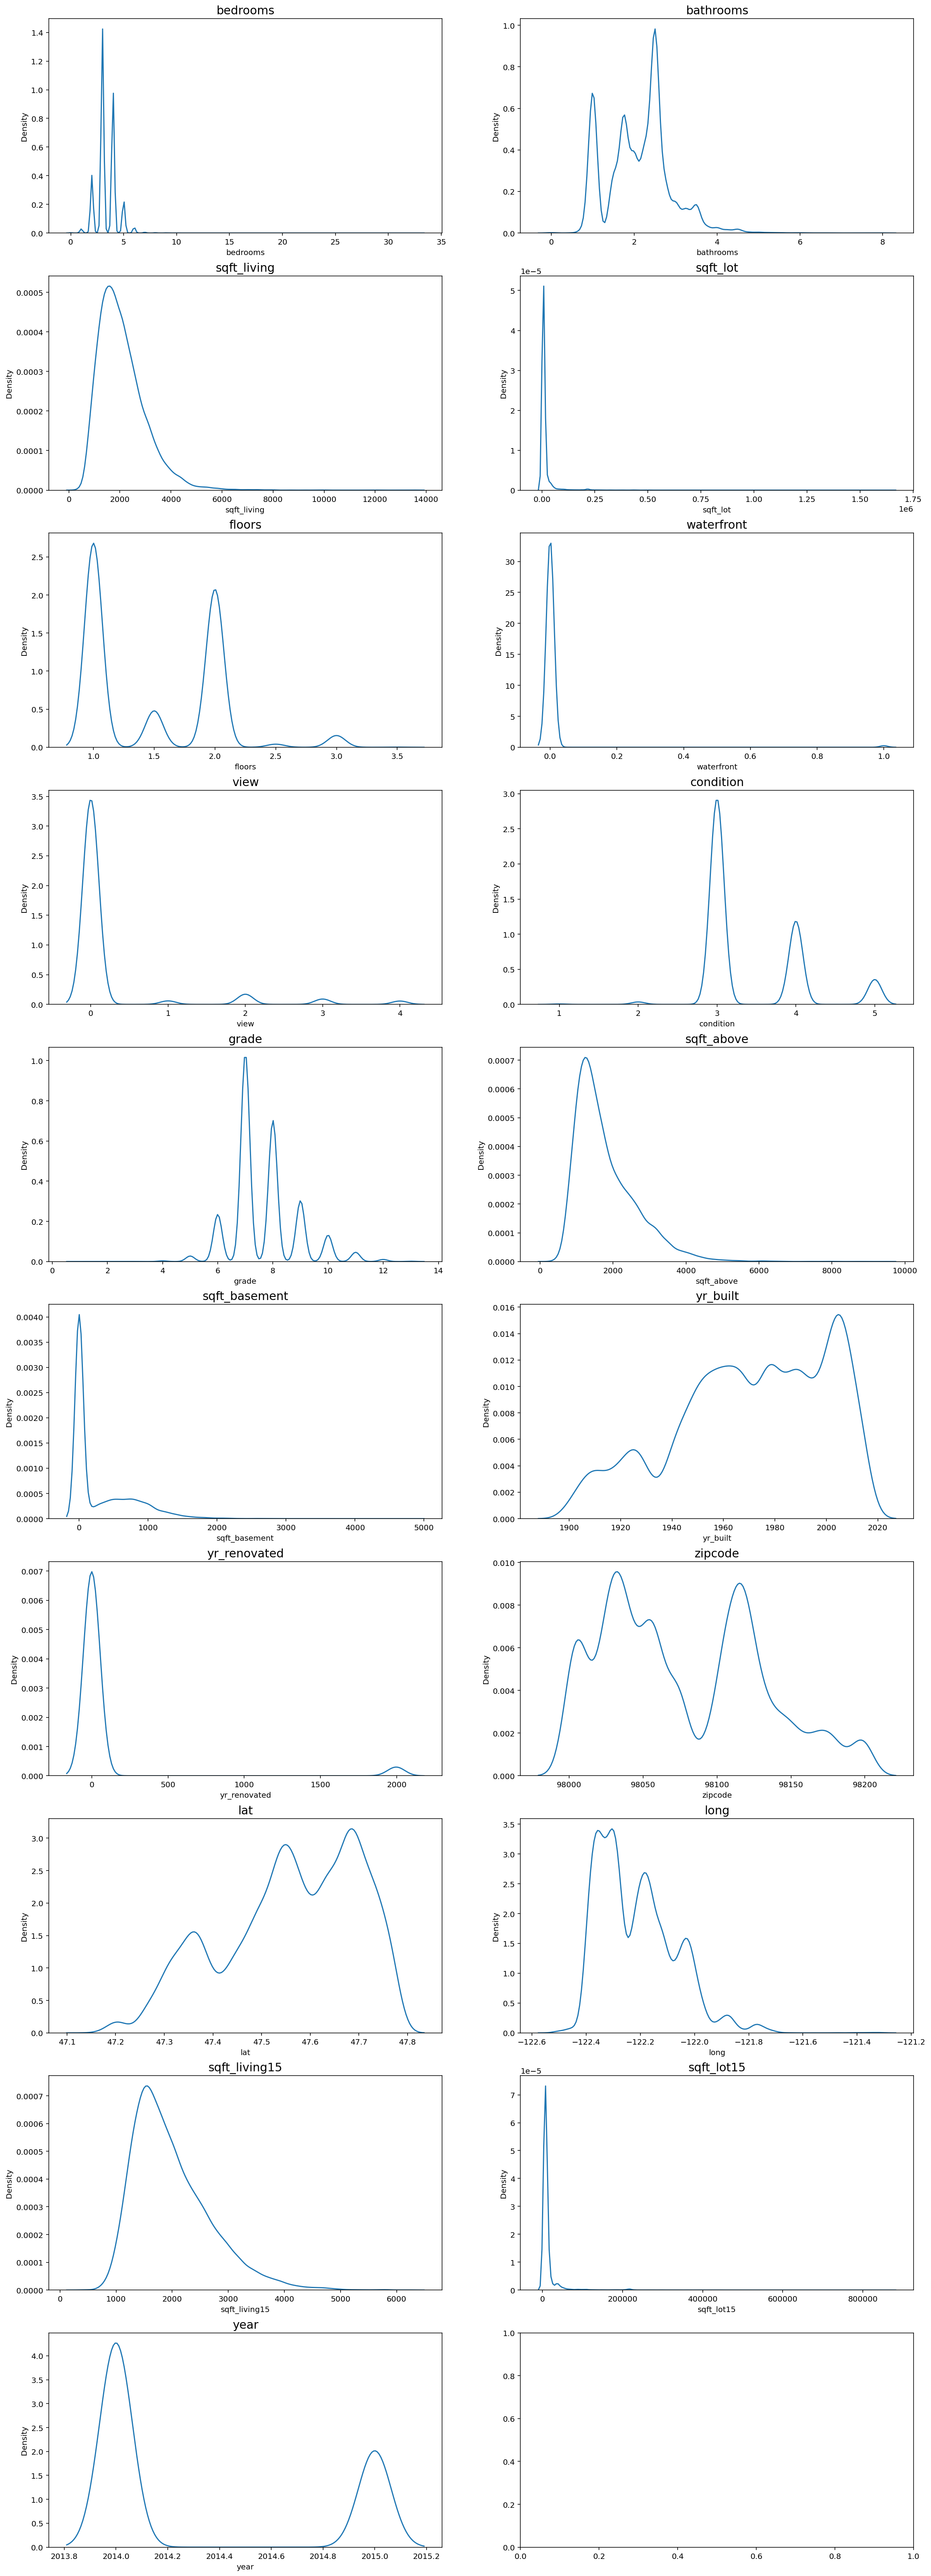

In [336]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [337]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

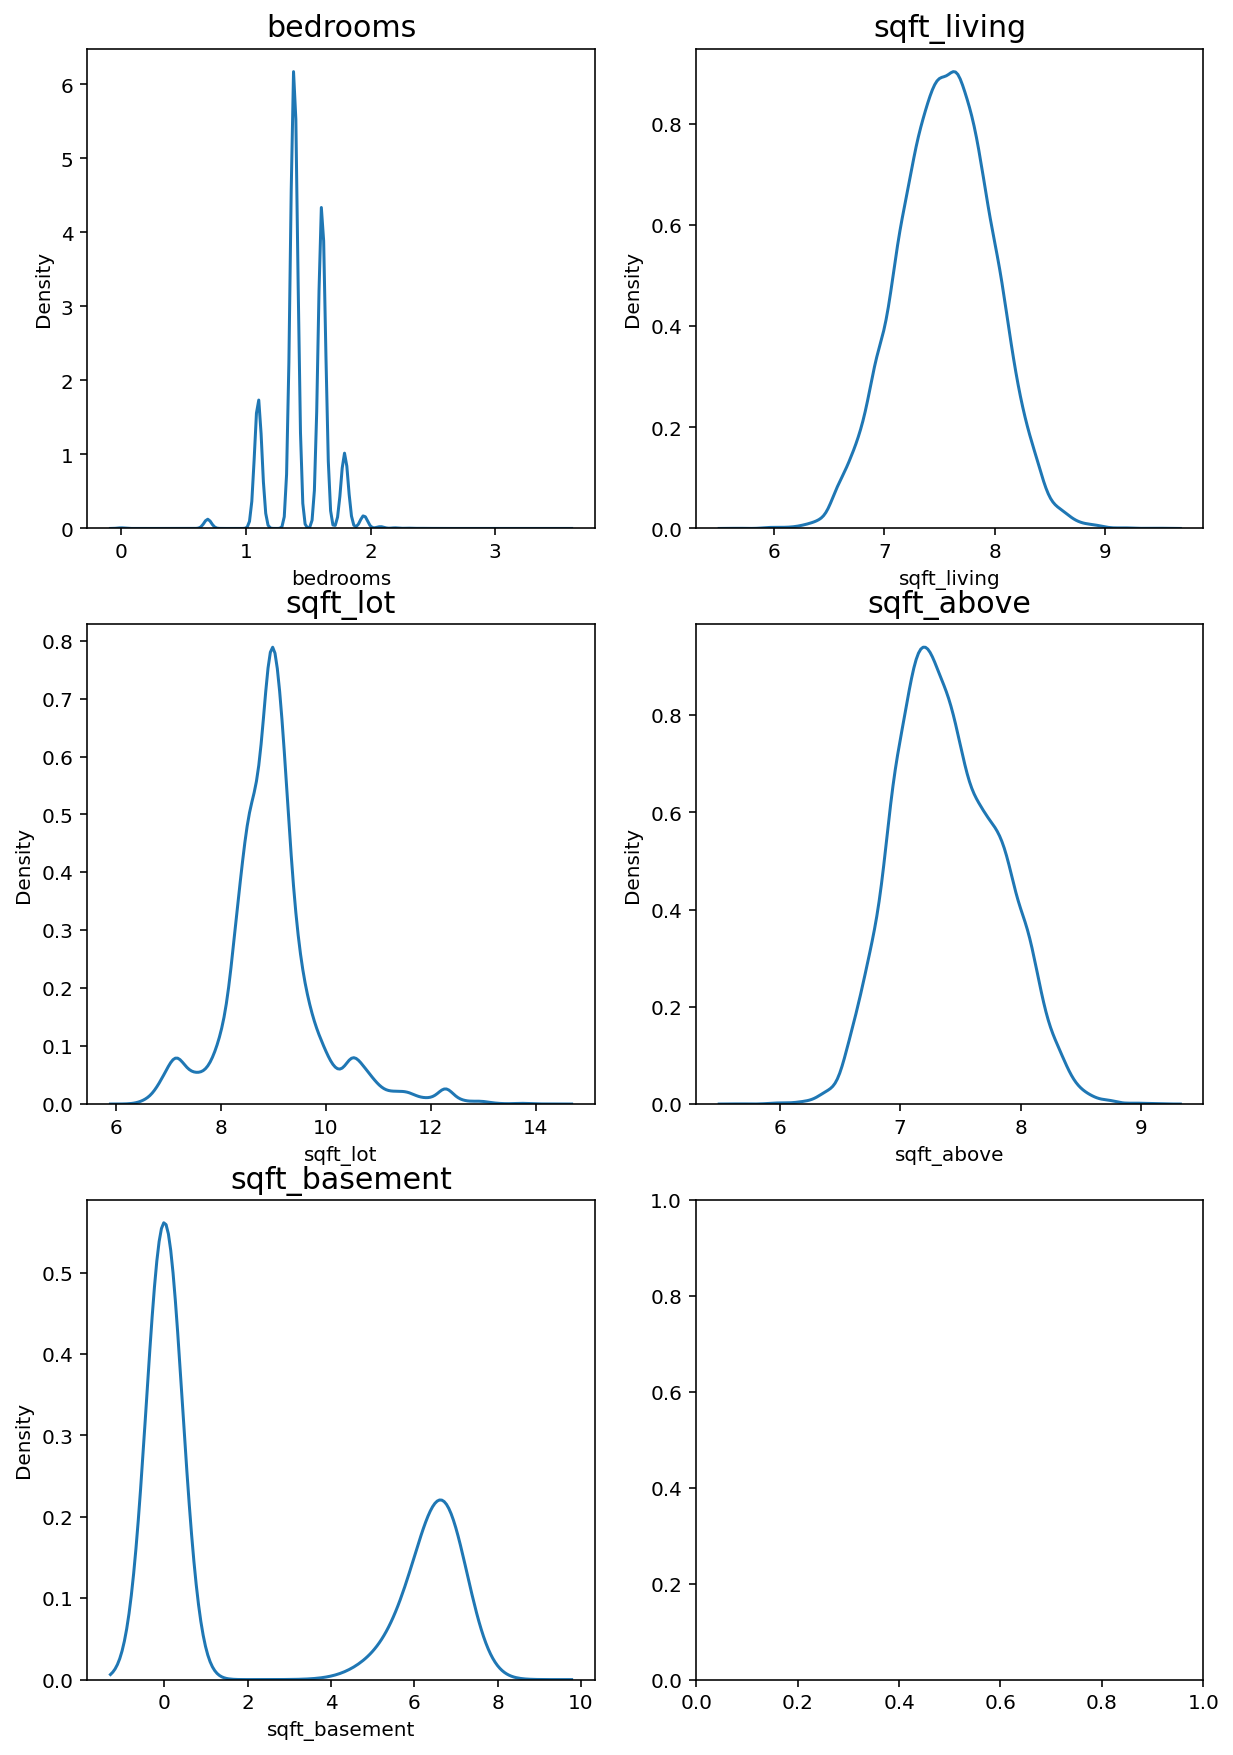

In [338]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [339]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21503 non-null  float64
 1   bathrooms      21503 non-null  float64
 2   sqft_living    21503 non-null  float64
 3   sqft_lot       21503 non-null  float64
 4   floors         21503 non-null  float64
 5   waterfront     21503 non-null  int64  
 6   view           21503 non-null  int64  
 7   condition      21503 non-null  int64  
 8   grade          21503 non-null  int64  
 9   sqft_above     21503 non-null  float64
 10  sqft_basement  21503 non-null  float64
 11  yr_built       21503 non-null  int64  
 12  yr_renovated   21503 non-null  int64  
 13  zipcode        21503 non-null  int64  
 14  lat            21503 non-null  float64
 15  long           21503 non-null  float64
 16  sqft_living15  21503 non-null  int64  
 17  sqft_lot15     21503 non-null  int64  
 18  year  

In [340]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [341]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)


models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},{'model':rdforest, 'name':'rdforest'}]


In [342]:
# RMSE 스코어 설정
rmse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE를 계산하도록 설정

# 교차 검증 스코어 계산 함수
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019)
    for m in models:
        # RMSE 기준으로 cross_val_score 계산
        cv_score = cross_val_score(m['model'], x.values, y, cv=kfold, scoring=rmse_scorer)
        print("Model {} CV RMSE : {:.4f}".format(m['name'], np.mean(cv_score)))

# 함수 호출
get_cv_score(models)

Model GradientBoosting CV RMSE : 138090.3496
Model XGBoost CV RMSE : 127791.5528
Model LightGBM CV RMSE : 131134.4977
Model rdforest CV RMSE : 135368.6222


### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

### 하이퍼파라미터 따라가기

In [343]:
train_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'train.csv')
test_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [344]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

In [345]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

In [346]:
y = train['price']
del train['price']

print(train.columns)
del train['id']

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [347]:
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


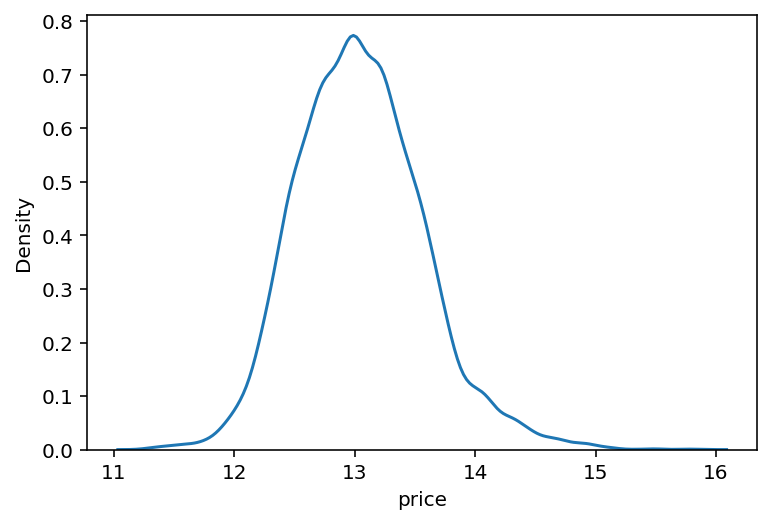

In [348]:
y = np.log1p(y)
y
sns.kdeplot(y)
plt.show()

In [349]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [350]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [351]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [352]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [353]:
def get_scores(models, train, y):
    results = {}  # 결과를 저장할 딕셔너리
    
    # 각 모델에 대해 학습 및 RMSE 계산
    for model in models:
        # 모델 이름
        model_name = model.__class__.__name__
        
        # Train/Test 데이터셋 분리 (8:2 비율)
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2020)
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)
        
        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # 결과 저장
        results[model_name] = rmse

    # DataFrame으로 변환 및 정렬
    score_df = pd.DataFrame(results, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

# 함수 호출 예시
get_scores(models, x, y)

RMSE
GradientBoostingRegressor  0.182404
RandomForestRegressor      0.177653
XGBRegressor               0.166894
LGBMRegressor              0.163727

In [354]:
from sklearn.model_selection import GridSearchCV

In [355]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [356]:
model = LGBMRegressor(random_state=random_state)

In [357]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [358]:
grid_model.cv_results_

{'mean_fit_time': array([0.38888683, 0.49459505, 1.15019431, 1.63760753]),
 'std_fit_time': array([0.11764331, 0.20816131, 0.12429437, 0.20768394]),
 'mean_score_time': array([0.02354436, 0.04395046, 0.06900001, 0.07373447]),
 'std_score_time': array([0.01439024, 0.02623567, 0.02185143, 0.01966018]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [359]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [360]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [361]:
results = pd.DataFrame(params)
results['score'] = score
results['RMSE'] = np.sqrt(-1 * results['score'])

# RMSE를 RMSLE로 열 이름 변경
results = results.rename(columns={'RMSE': 'RMSLE'})

# 결과 확인
results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.073394  0.270914
1          1           100 -0.055020  0.234564
2         10            50 -0.029177  0.170814
3         10           100 -0.027027  0.164399

In [362]:
# 결과 확인
results
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [363]:
sub = pd.DataFrame(data={'id': sub_id, 'price': prediction})

In [364]:
sub.to_csv('submission6.csv', index=False)

### 시도 1

* 오늘 프로젝트의 가장 큰 패착은 데이터 부족, 독립 변수의 부족, 관점의 차이 등이 아니었다. 
* 진정 문제는 바로 심오한 부동산의 세계에 나의 하잘 것 없는 식견을 '강요하듯' 첨부하려 시도했다는 점이다.
* 편협했고, 또, 무지했다. 
* 통계학에서 베이지안이 사장된 이후로 데이터 분석은 언제나 질보다는 양이었다. 

In [33]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
train_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'train.csv')
test_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [36]:
train['price']

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [37]:
train['price'] = np.log1p(train['price'])

In [38]:
train['price']

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [6]:
train.shape

(15035, 21)

In [7]:
test.shape

(6468, 20)

* 분포의 정규화

In [39]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for i in skew_columns:
    train[i] = np.log1p(train[i].values)

* 굉장히 거슬리는 이상치나, 놀랍게도 이런 식으로 이상치를 제거한 값들의 rmse가 더 컸다. 
* rmse는 이상치의 민감하지 않던가. 실로 놀라운 일이다

In [376]:
train['sqft_lot15'] = np.where(train['sqft_lot15'] >= 500000, np.nan,train['sqft_lot15'])
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)

In [40]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

* 왜 date를 아래와 같은 방법으로 더럽히는가. 그 해답은 다중공선성 파트에서 나온다.

In [378]:
train['date'] = train['date'].astype('int64')
train['date'] = pd.to_datetime(train['date'], format='%Y%m')
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train = train.drop(columns=['date'])
test['date'] = test['date'].astype('int64')
test['date'] = pd.to_datetime(test['date'], format='%Y%m')
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test = test.drop(columns=['date'])

In [379]:
train.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month'],
      dtype='object')

4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수(.5는 화장실은 있으나 샤워실은 없는 방)
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도(0~4)
11. condition : 집의 전반적인 상태(1~5)
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
* 1부터13의 지수, 여기서 1,2,3은 건물 구조 및 설계에 미달하고, 7은 평균 수준의 구조 및 설계이며, 11,12,13은 고품질 수준의 구조 및 설계를 나타냅니다.
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 해당 주택을 기준으로 주변 15개 주택의 주거 공간 평균 면적
21. sqft_lot15 : 주변 15개 주택의 부지 면적 평균

* 어떻게든 인사이트를 뽑아내려는 노력이 이제부터 시작된다.

In [278]:
# # 지하실 제외 실제 거주 평수 / 부지 평수

# train['real_living']=train['sqft_above']/train['sqft_lot']
# test['real_living']=test['sqft_above']/test['sqft_lot']

# 의미없다.

In [41]:
lat_bins = np.linspace(train['lat'].min(), train['lat'].max(), num=50)
long_bins = np.linspace(train['long'].min(), train['long'].max(), num=50)

train['lat_bin'] = np.digitize(train['lat'], bins=lat_bins)
train['long_bin'] = np.digitize(train['long'], bins=long_bins)

# 각 (lat_bin, long_bin) 조합에 대해 밀도(카운트) 계산
density_counts = train.groupby(['lat_bin', 'long_bin']).size().reset_index(name='density')

# 원래 데이터와 밀도 값 매칭
train = train.merge(density_counts, on=['lat_bin', 'long_bin'], how='left')

# 필요 없는 열 삭제
train.drop(['lat_bin', 'long_bin'], axis=1, inplace=True)

# 결과 확인
train[['lat', 'long', 'density']].head()

lat     long  density
0  47.5112 -122.257       31
1  47.7379 -122.233       62
2  47.6168 -122.045       47
3  47.3097 -122.327       29
4  47.4095 -122.315       25

In [253]:
### 위도 경도가 0.0001단위까지 똑같으면 11 미터 이내 값. 
### 즉, 시애틀에서 타운 하우스 or 아파트에 사는 밀도라고 추정할 수 있다. 

* 처음엔 밀도를 뽑아내서 어떻게든 발악을 시도했으나, 유의미한 결과를 얻어내진 못했다.

In [42]:
lat_bins = np.linspace(train['lat'].min(), test['lat'].max(), num=50)
long_bins = np.linspace(train['long'].min(), test['long'].max(), num=50)

test['lat_bin'] = np.digitize(test['lat'], bins=lat_bins)
test['long_bin'] = np.digitize(test['long'], bins=long_bins)

# 각 (lat_bin, long_bin) 조합에 대해 밀도(카운트) 계산
density_counts = test.groupby(['lat_bin', 'long_bin']).size().reset_index(name='density')

# 원래 데이터와 밀도 값 매칭
test = test.merge(density_counts, on=['lat_bin', 'long_bin'], how='left')

# 필요 없는 열 삭제
test.drop(['lat_bin', 'long_bin'], axis=1, inplace=True)

# 결과 확인
test[['lat', 'long', 'density']].head()

lat     long  density
0  47.7210 -122.319       25
1  47.5208 -122.393       21
2  47.6561 -122.005        6
3  47.5123 -122.337       21
4  47.3684 -122.031       30

* 위 코드와 섞여서 id는 다시 삭제한다.

In [43]:
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

* 허나, 보는바와 같이 특이점을 도출하기란 요원했다.

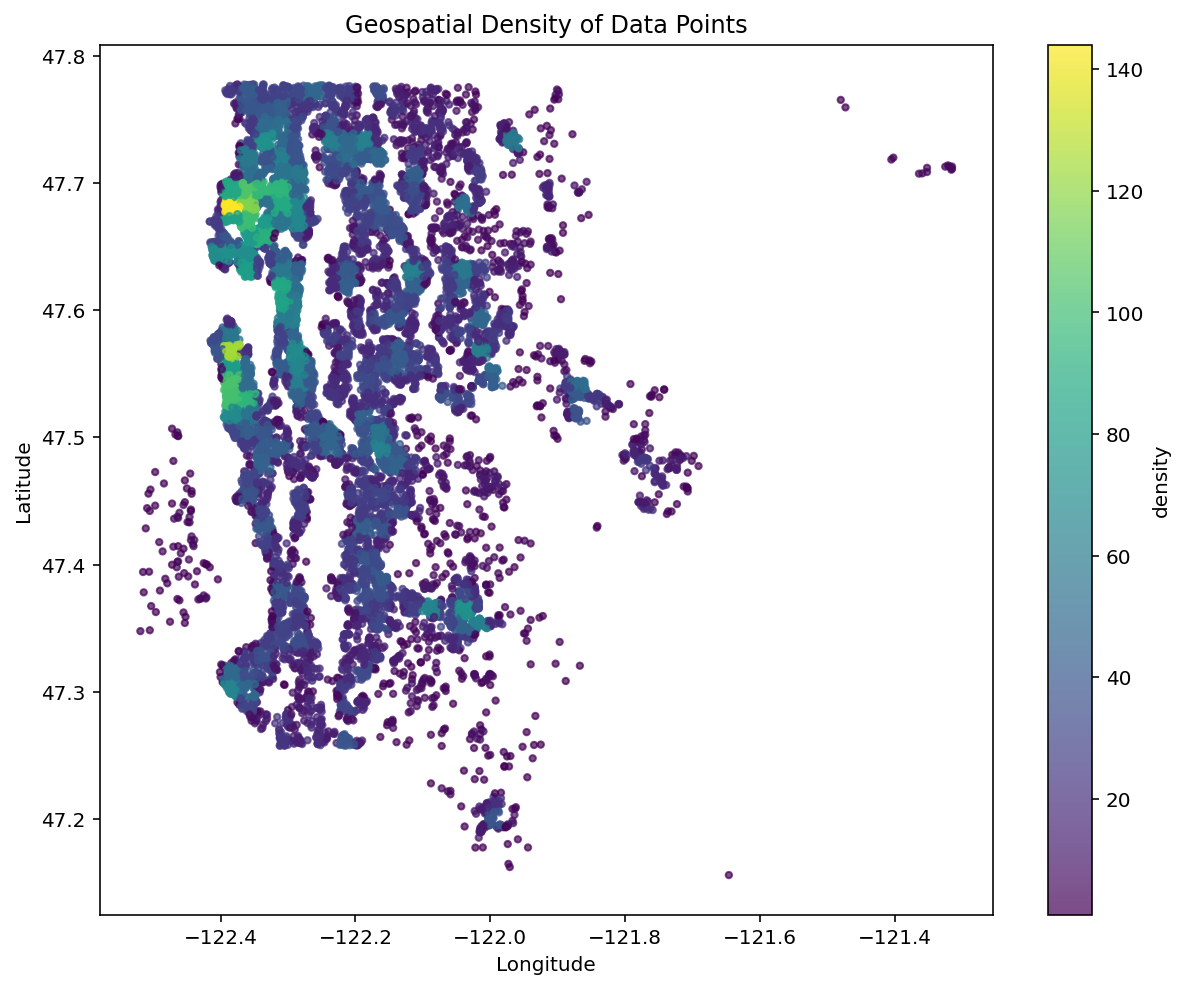

In [383]:
plt.figure(figsize=(10, 8))
density_plot = plt.scatter(train['long'], train['lat'], c=train['density'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(density_plot, label='density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Density of Data Points')
plt.show()

* 하나. 의미가 있던 것은 부촌을 특정할 수 있었다는 점이다. 아래 그림처럼

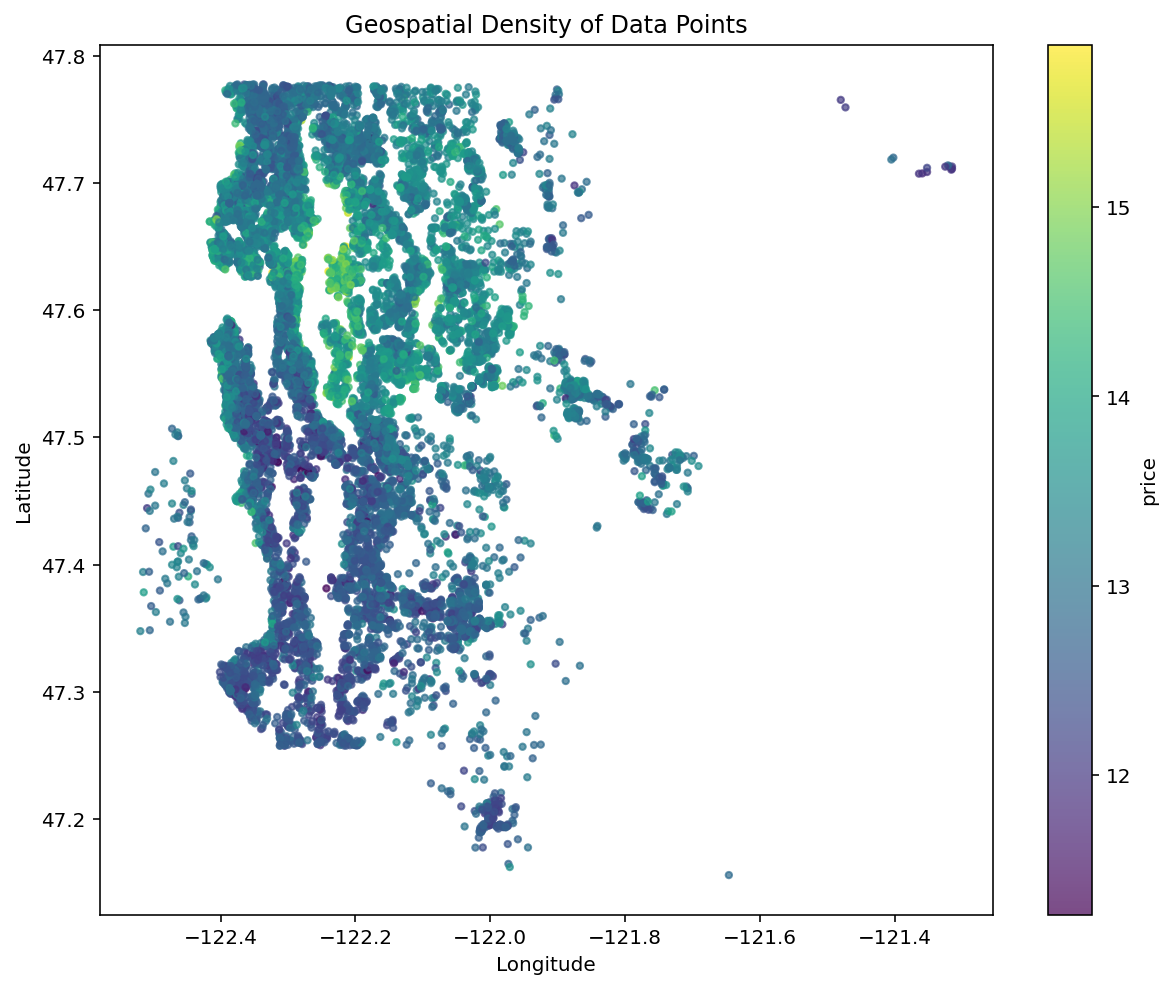

In [384]:
plt.figure(figsize=(10, 8))
density_plot = plt.scatter(train['long'], train['lat'], c=train['price'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(density_plot, label='price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Density of Data Points')
plt.show()

* 격자를 그려넣고 평균을 계산하여, 비교하여 높은 지역을 부촌으로 특정한다.

In [44]:
# 경위도를 격자 형태로 변환
grid_size = 0.01  # 격자 크기 (적절히 조정 가능)
train['lat_bin'] = (train['lat'] // grid_size) * grid_size
train['long_bin'] = (train['long'] // grid_size) * grid_size

# 각 격자의 평균 가격 계산
grid_avg_price = train.groupby(['lat_bin', 'long_bin'])['price'].mean().reset_index()
grid_avg_price.columns = ['lat_bin', 'long_bin', 'avg_price']

# train 데이터에 평균 가격 매핑
train = train.merge(grid_avg_price, on=['lat_bin', 'long_bin'], how='left')

# 평균 가격이 높은 지역에 대해 부촌 변수 생성
high_price_threshold = train['avg_price'].quantile(0.80)  # 상위 20%를 부촌으로 간주
train['is_high_price_area'] = (train['avg_price'] >= high_price_threshold).astype(int)

# test 데이터에 동일한 격자 매핑
test['lat_bin'] = (test['lat'] // grid_size) * grid_size
test['long_bin'] = (test['long'] // grid_size) * grid_size

# test 데이터에 부촌 여부 매핑
test = test.merge(grid_avg_price[['lat_bin', 'long_bin', 'avg_price']], on=['lat_bin', 'long_bin'], how='left')
test['is_high_price_area'] = (test['avg_price'] >= high_price_threshold).astype(int)

# 결측치 처리 (부촌 여부를 알 수 없는 지역은 0으로 설정)
test['is_high_price_area'].fillna(0, inplace=True)

# 필요 없는 컬럼 제거 (lat_bin, long_bin 등)
train = train.drop(columns=['lat_bin', 'long_bin', 'avg_price'])
test = test.drop(columns=['lat_bin', 'long_bin', 'avg_price'])

# 결과 확인
print(train[['lat', 'long', 'is_high_price_area']].head())
print(test[['lat', 'long', 'is_high_price_area']].head())

       lat     long  is_high_price_area
0  47.5112 -122.257                   0
1  47.7379 -122.233                   0
2  47.6168 -122.045                   0
3  47.3097 -122.327                   0
4  47.4095 -122.315                   0
       lat     long  is_high_price_area
0  47.7210 -122.319                   0
1  47.5208 -122.393                   0
2  47.6561 -122.005                   1
3  47.5123 -122.337                   0
4  47.3684 -122.031                   0


In [45]:
train['is_high_price_area'].value_counts()

0    12019
1     3016
Name: is_high_price_area, dtype: int64

In [46]:
test['is_high_price_area'].value_counts()

0    5184
1    1284
Name: is_high_price_area, dtype: int64

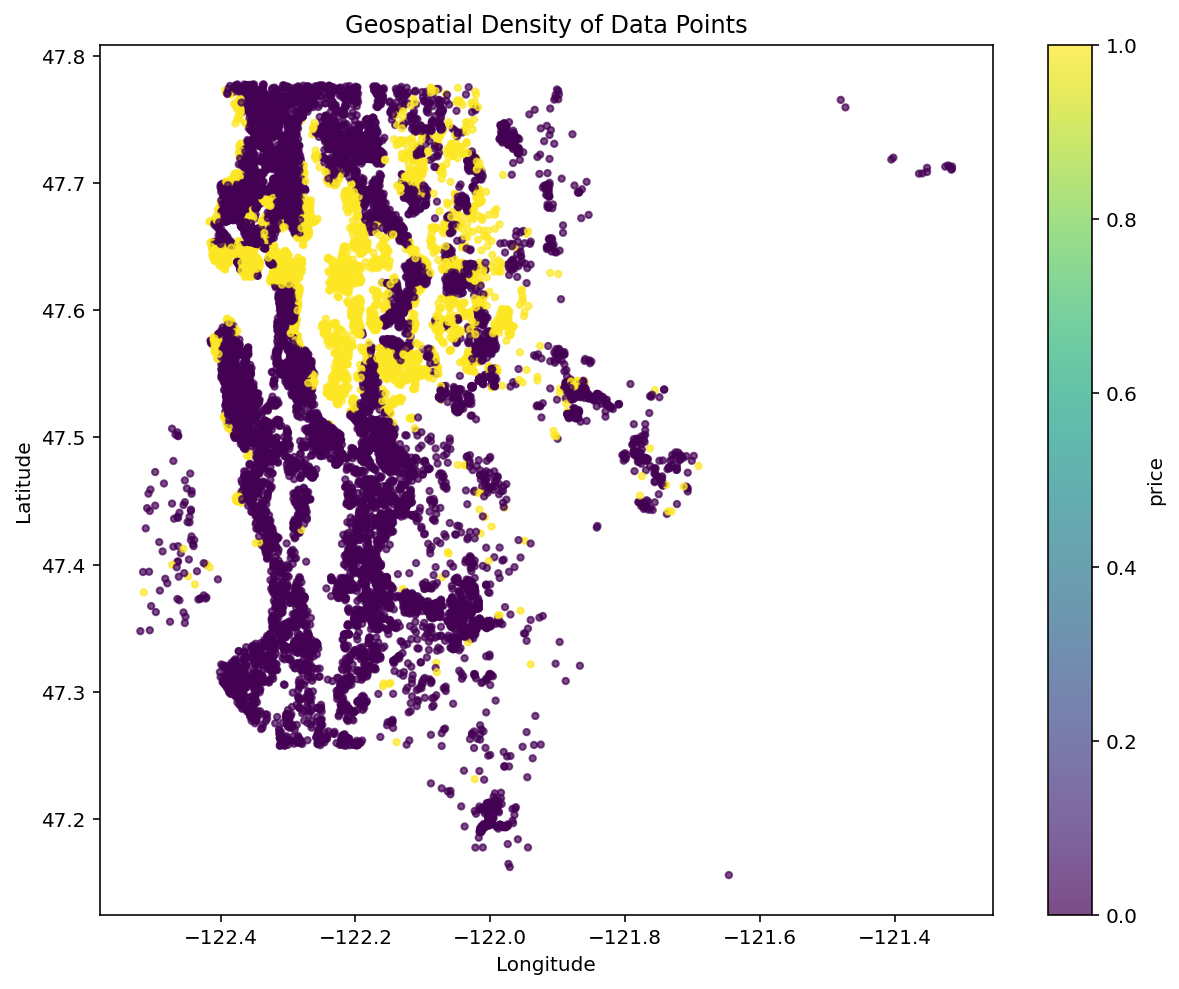

In [388]:
# 굉장히 관대하게 잡았다. 
plt.figure(figsize=(10, 8))
density_plot = plt.scatter(train['long'], train['lat'], c=train['is_high_price_area'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(density_plot, label='price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Density of Data Points')
plt.show()

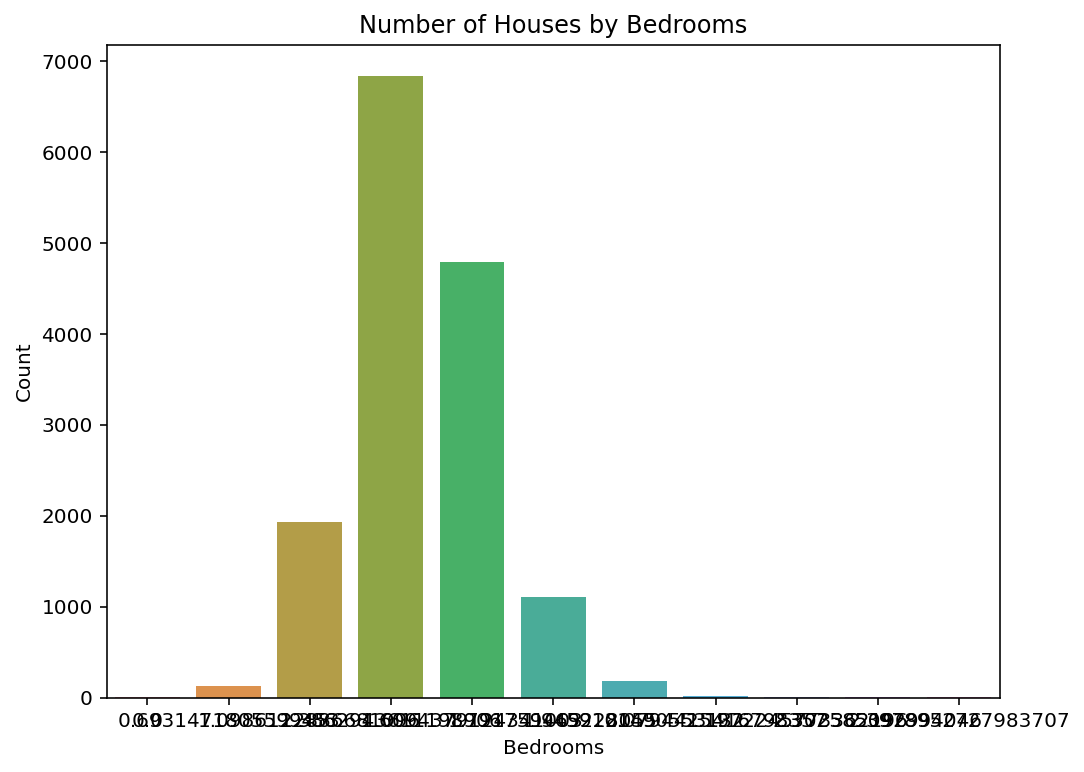

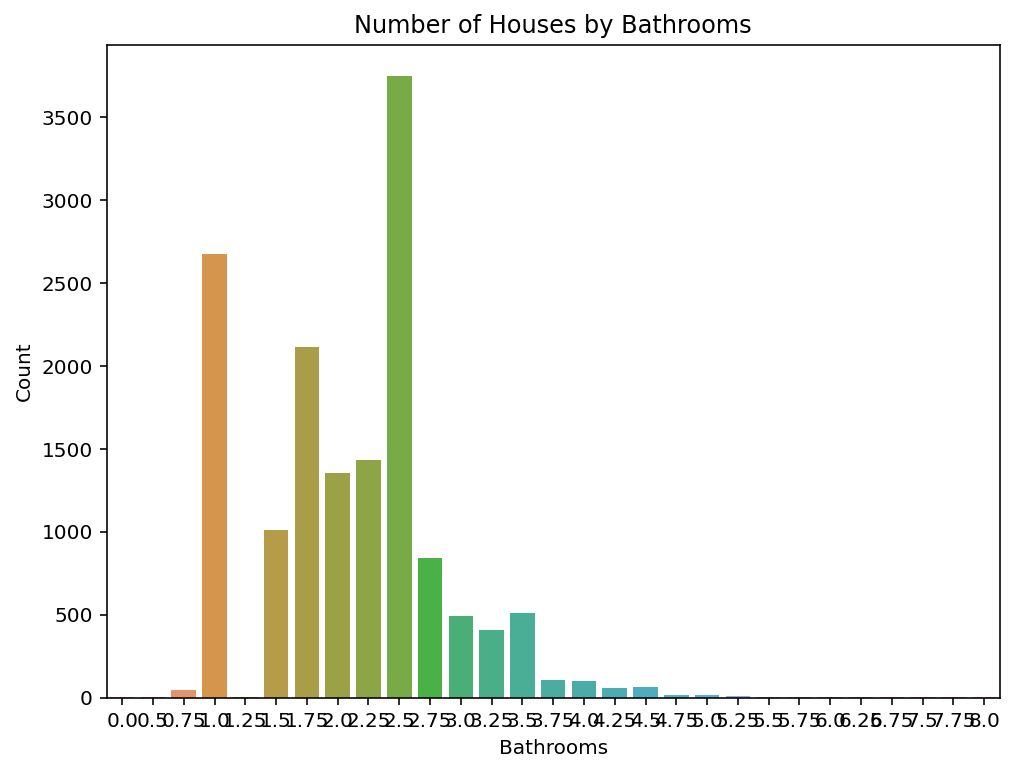

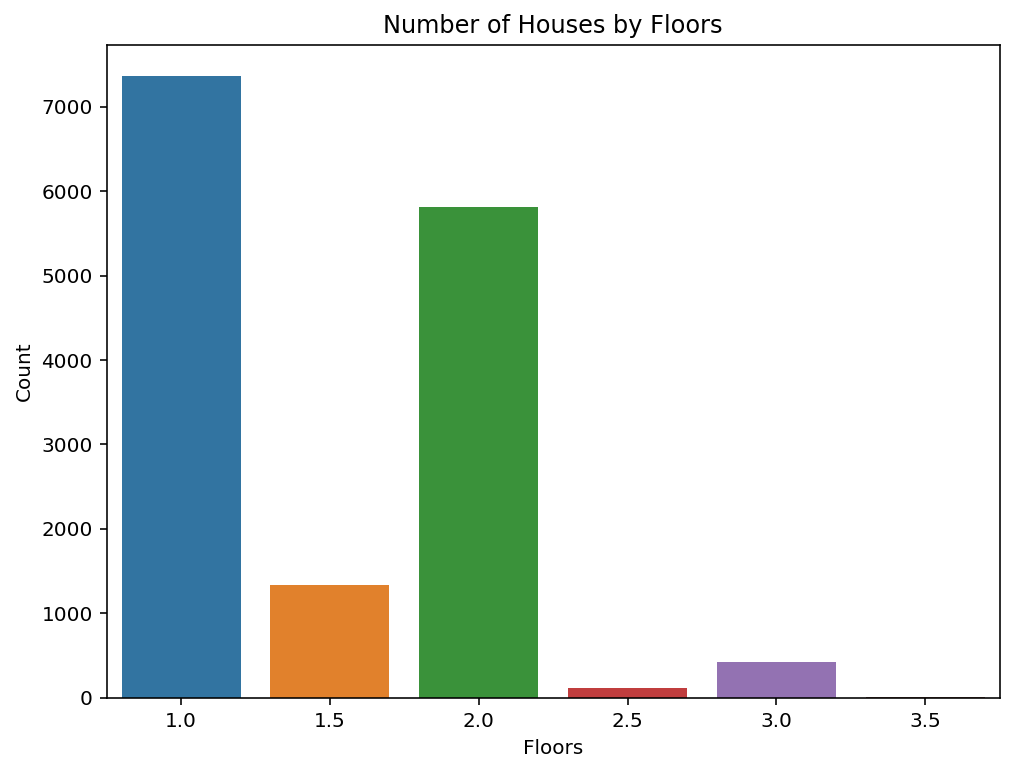

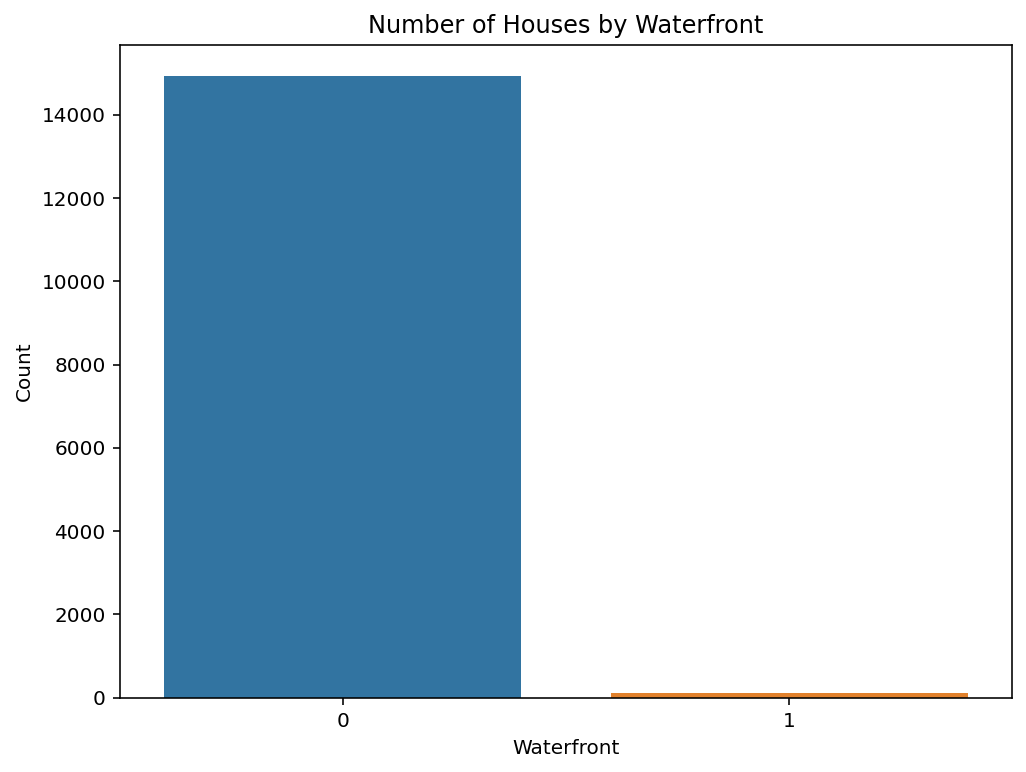

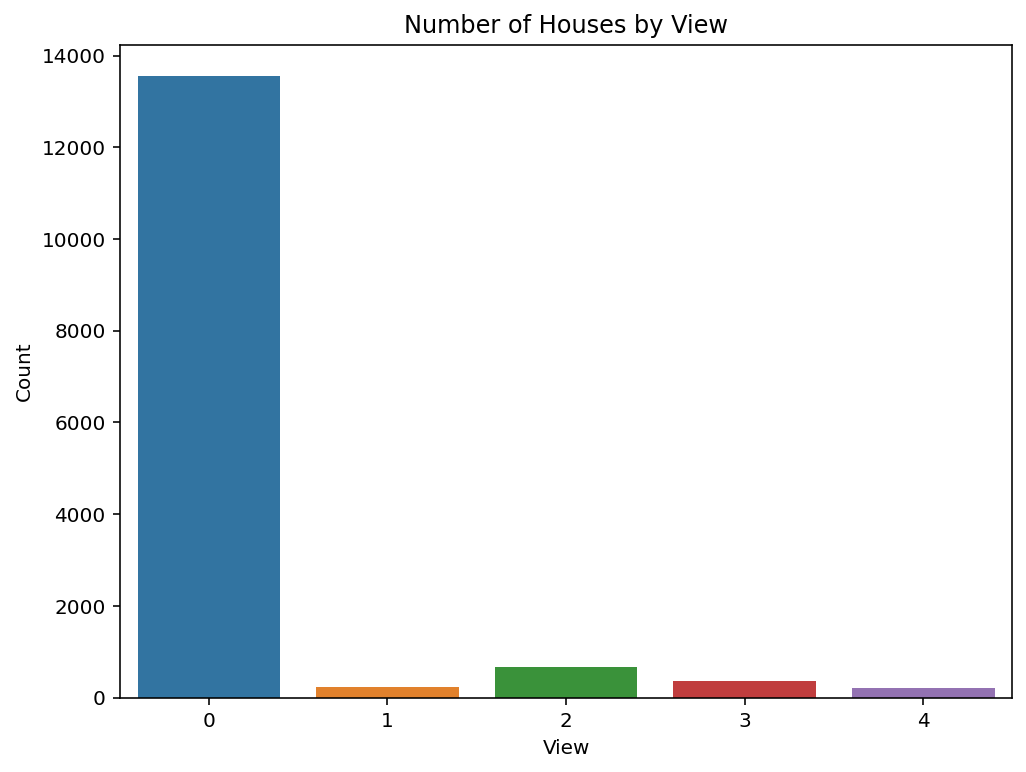

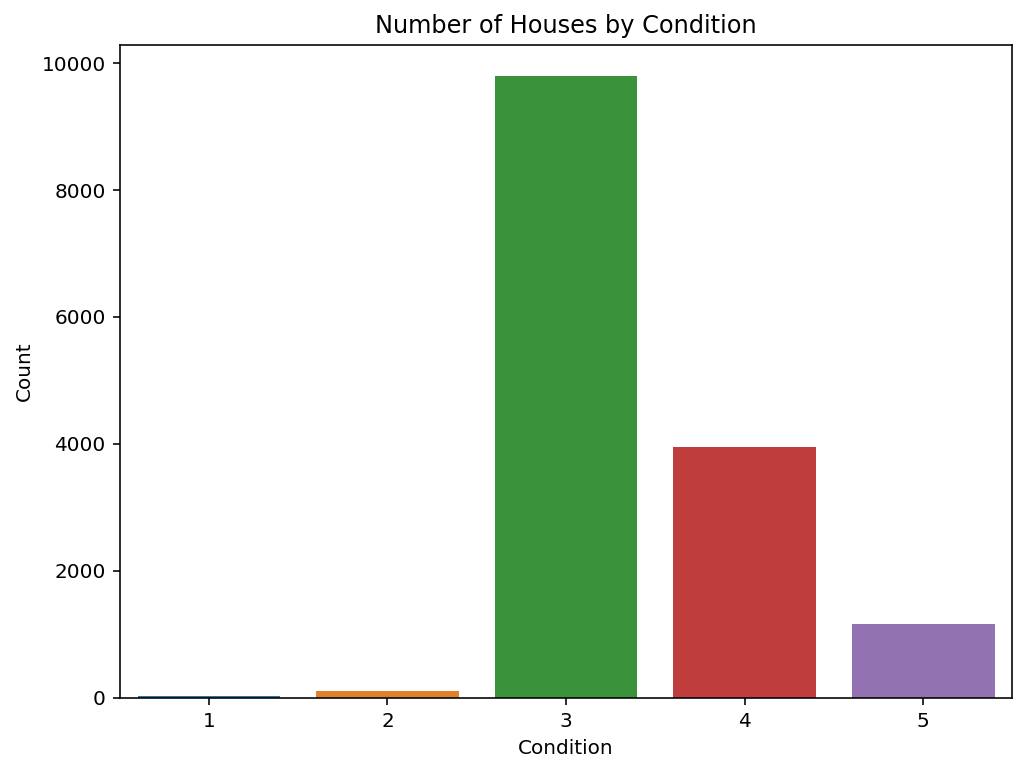

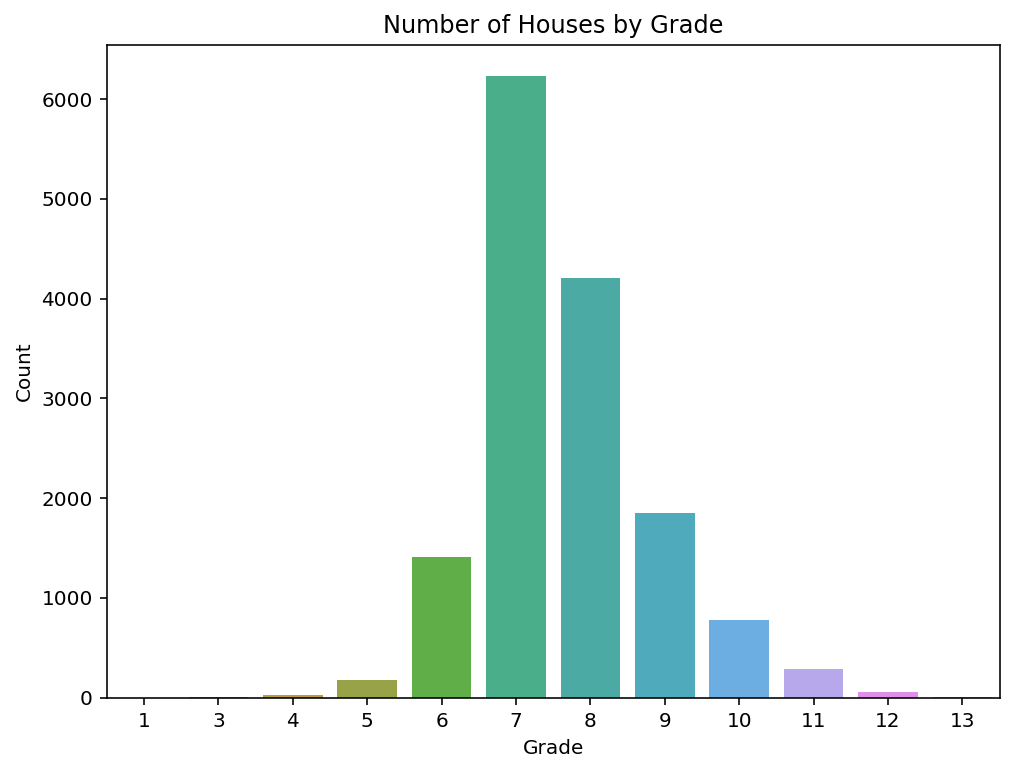

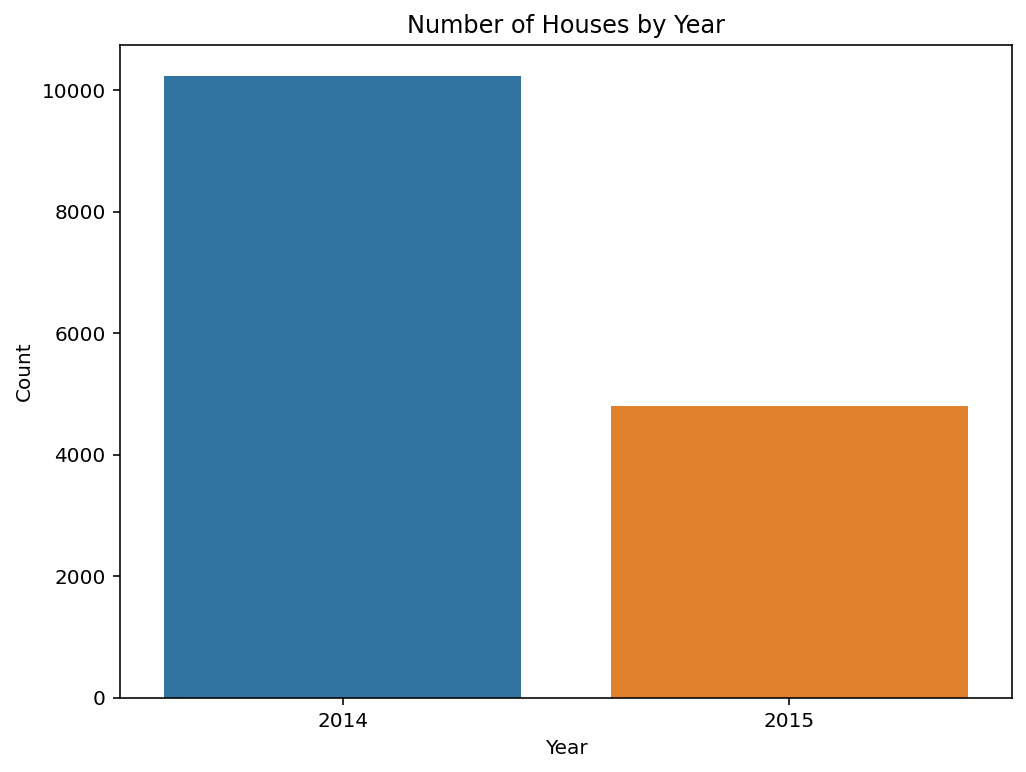

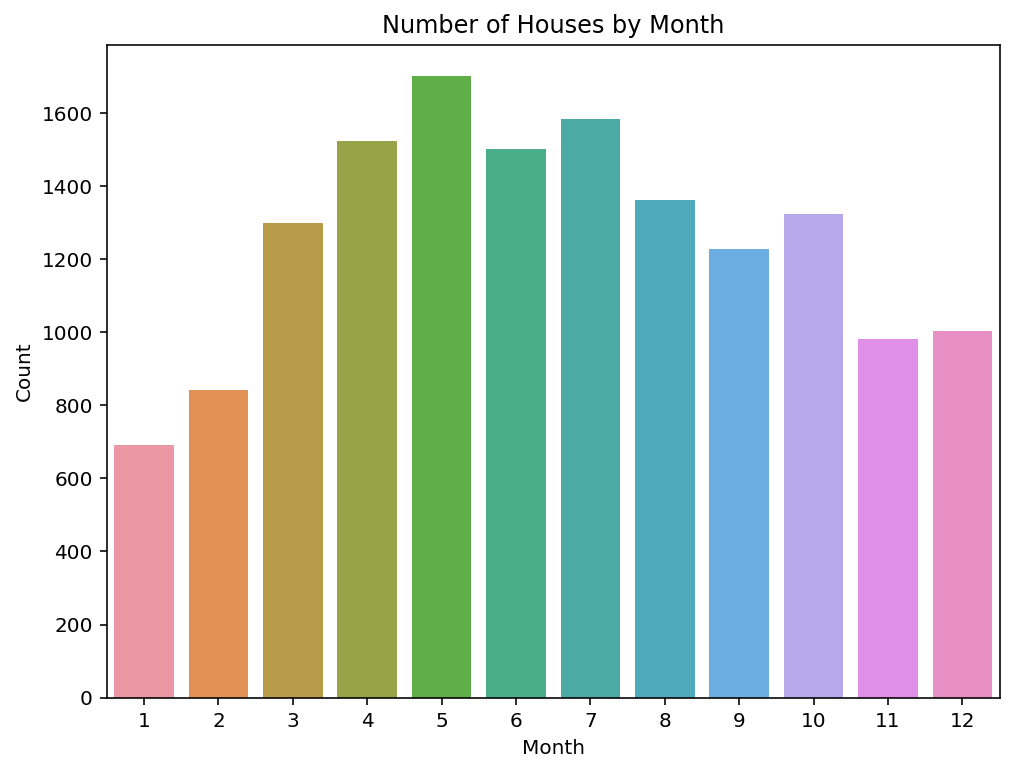

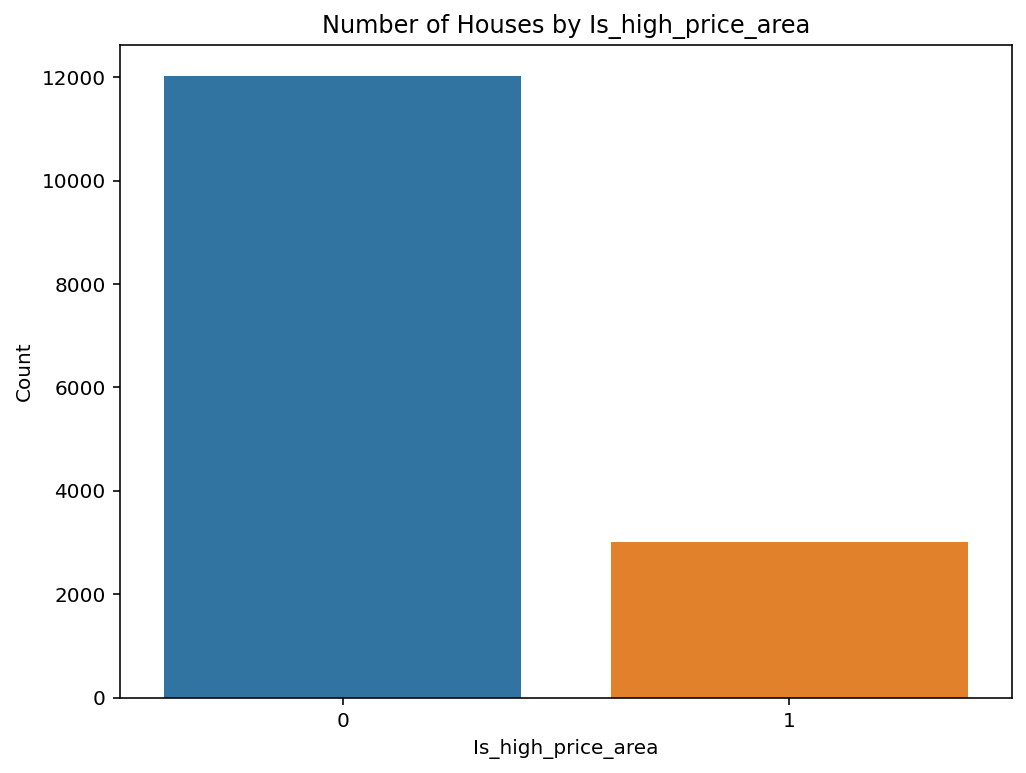

In [389]:
for col in train.columns:
    if train[col].nunique() <= 30:
        plt.figure(figsize=(8, 6))
        sns.barplot(x=train[col].value_counts().index, 
                    y=train[col].value_counts().values)
        plt.xlabel(col.capitalize())
        plt.ylabel('Count')
        plt.title(f'Number of Houses by {col.capitalize()}')
        plt.show()

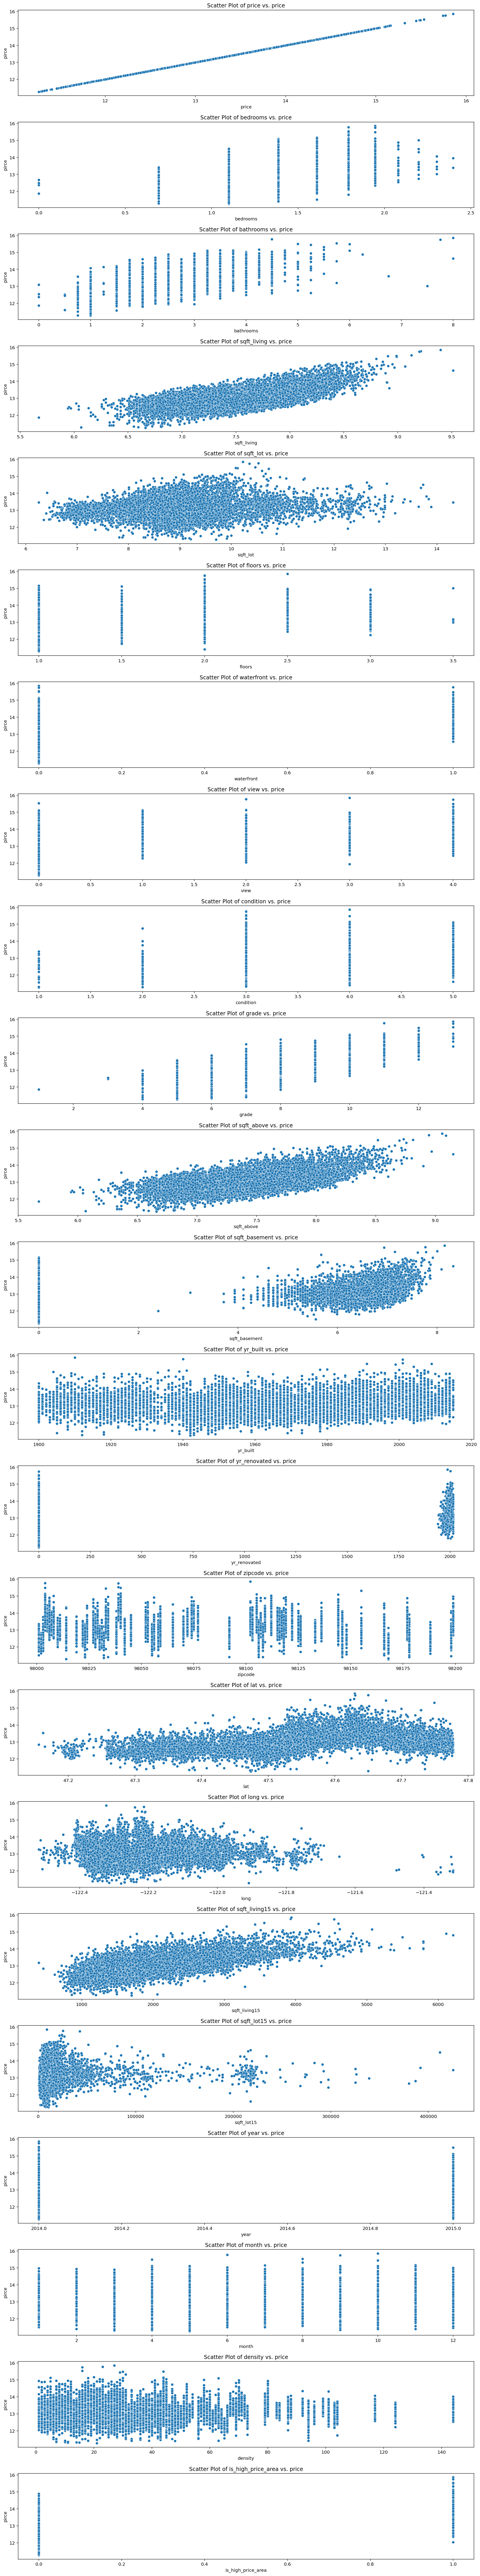

In [390]:
plt.figure(figsize=(15, 80))

for i, col in enumerate(train.columns, 1):
    plt.subplot(len(train.columns), 1, i)
    sns.scatterplot(x=train[col], y=train['price'])
    plt.title(f'Scatter Plot of {col} vs. price')
    plt.xlabel(col)
    plt.ylabel('pirce')

plt.tight_layout()
plt.show()

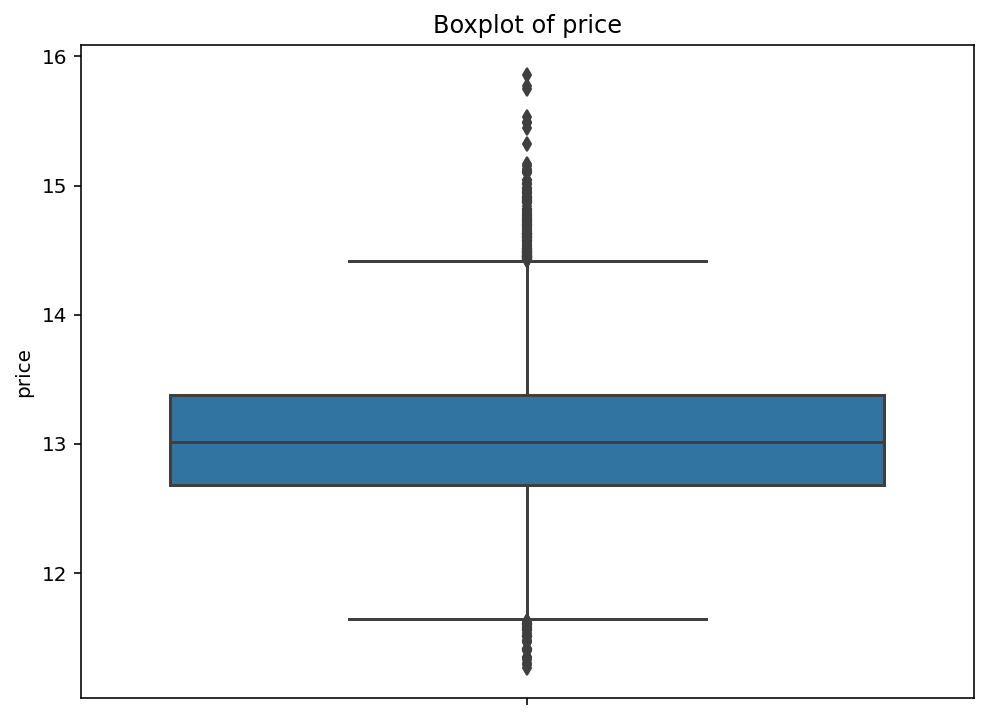

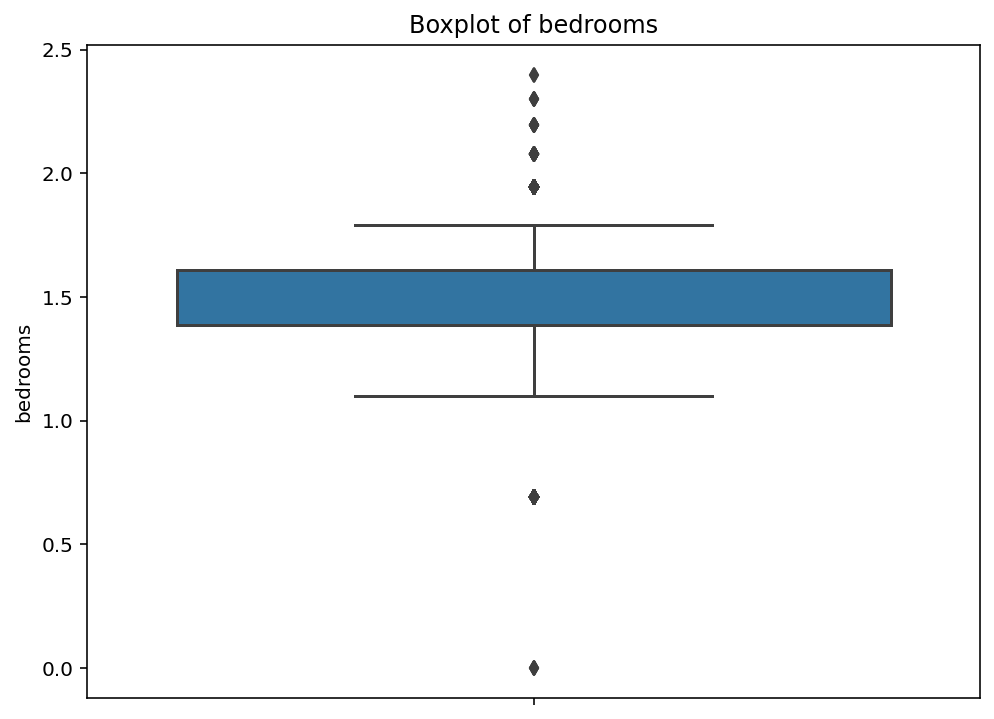

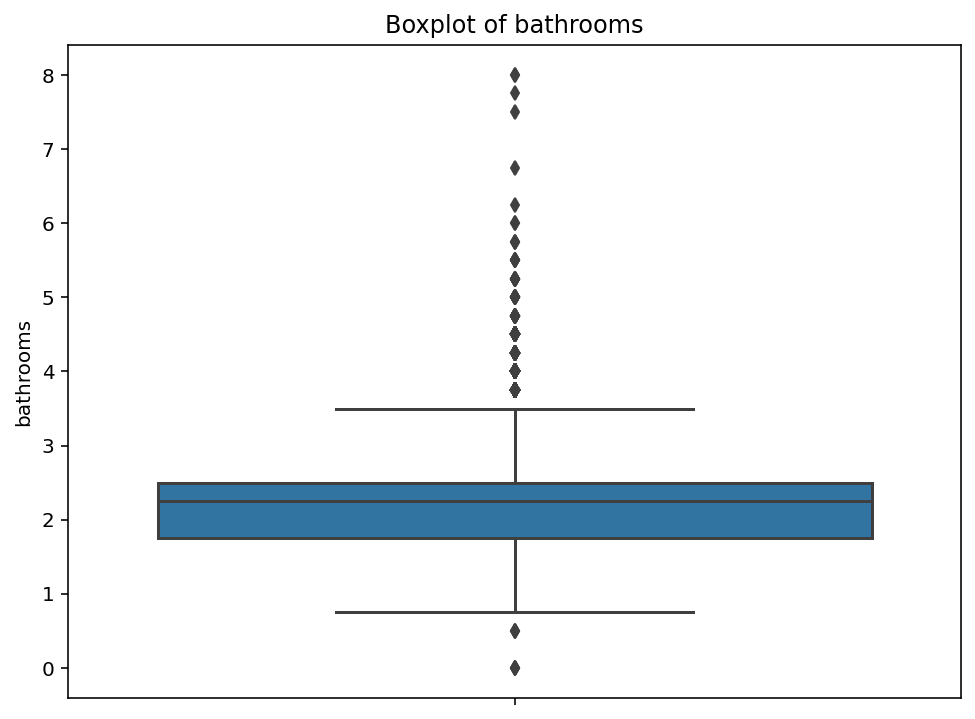

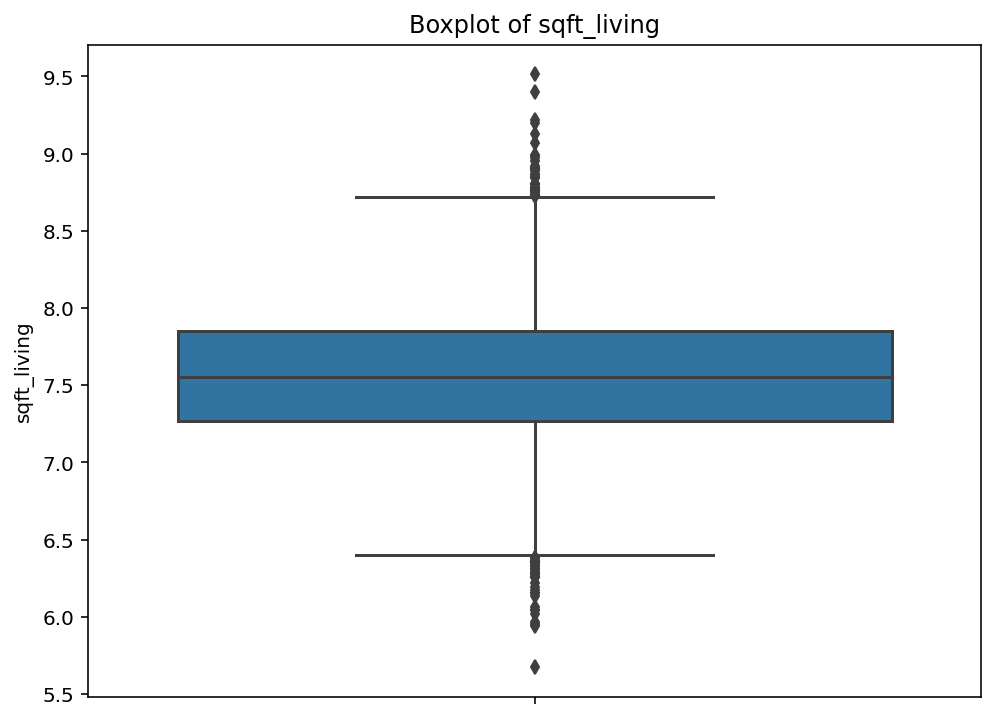

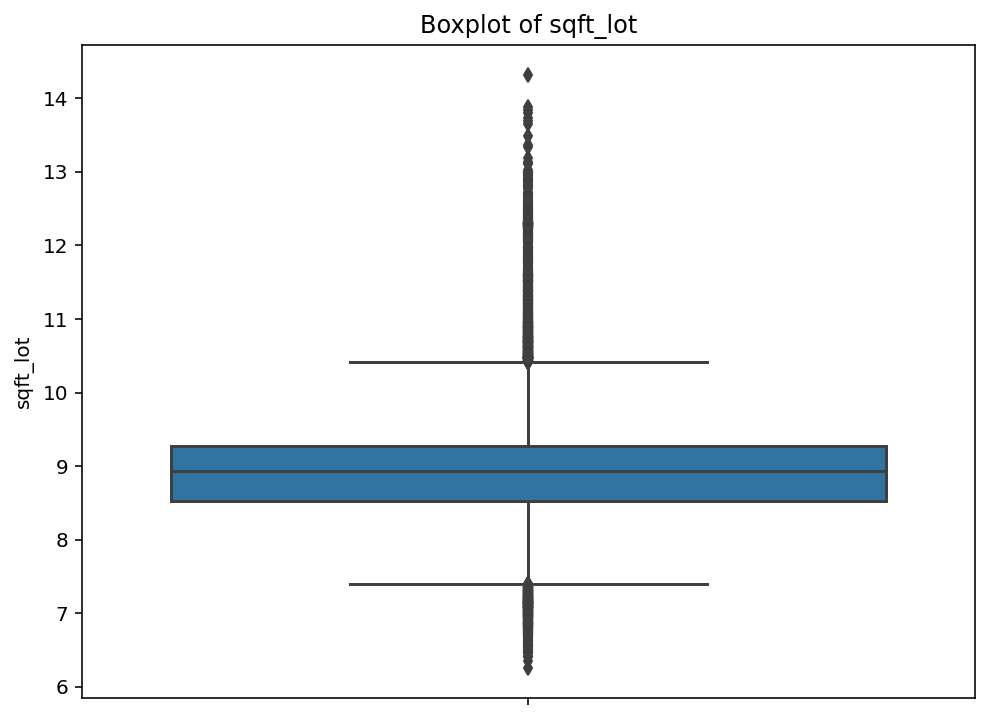

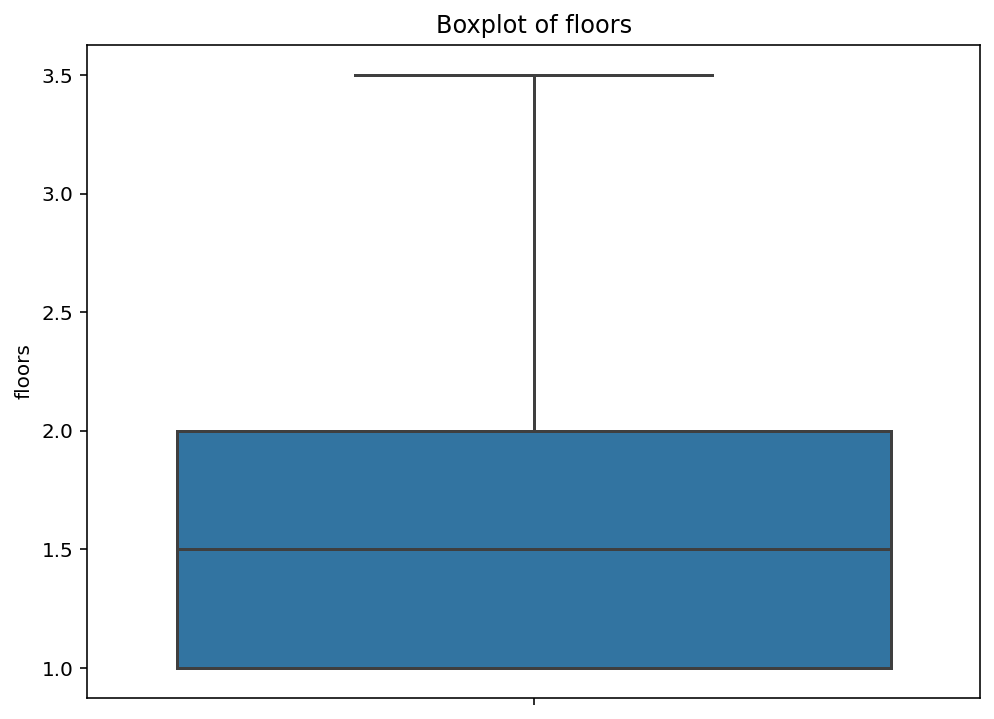

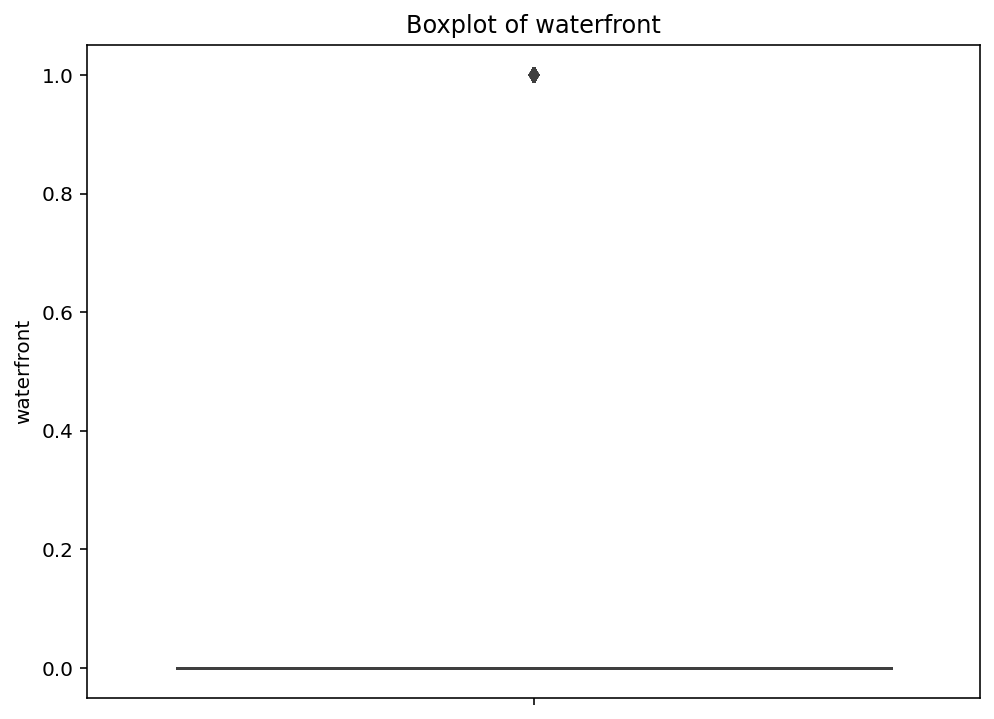

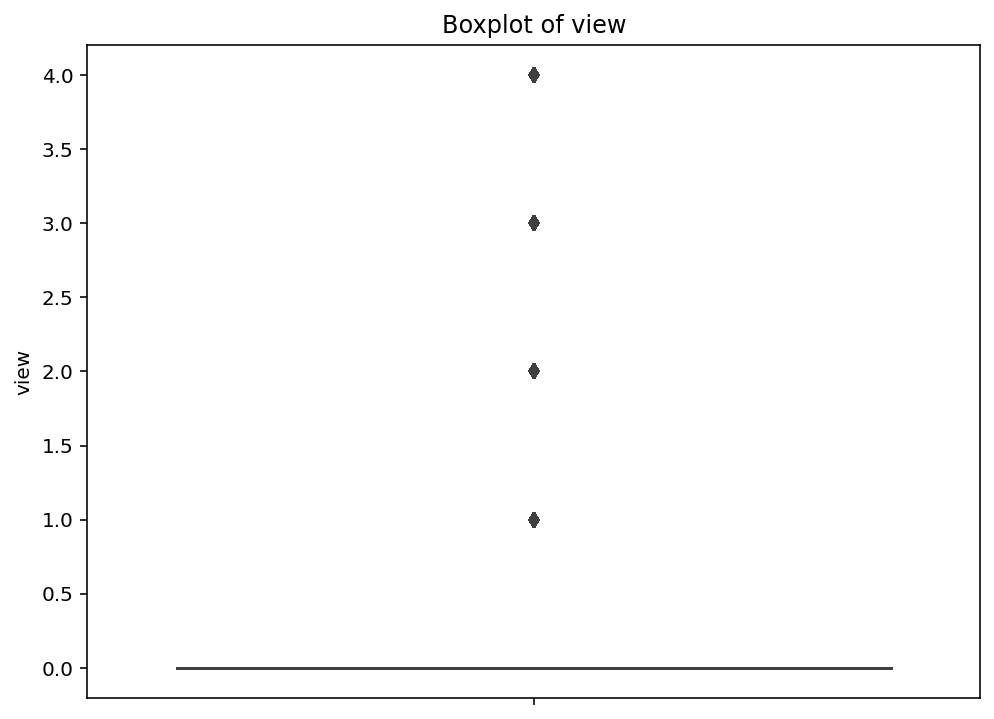

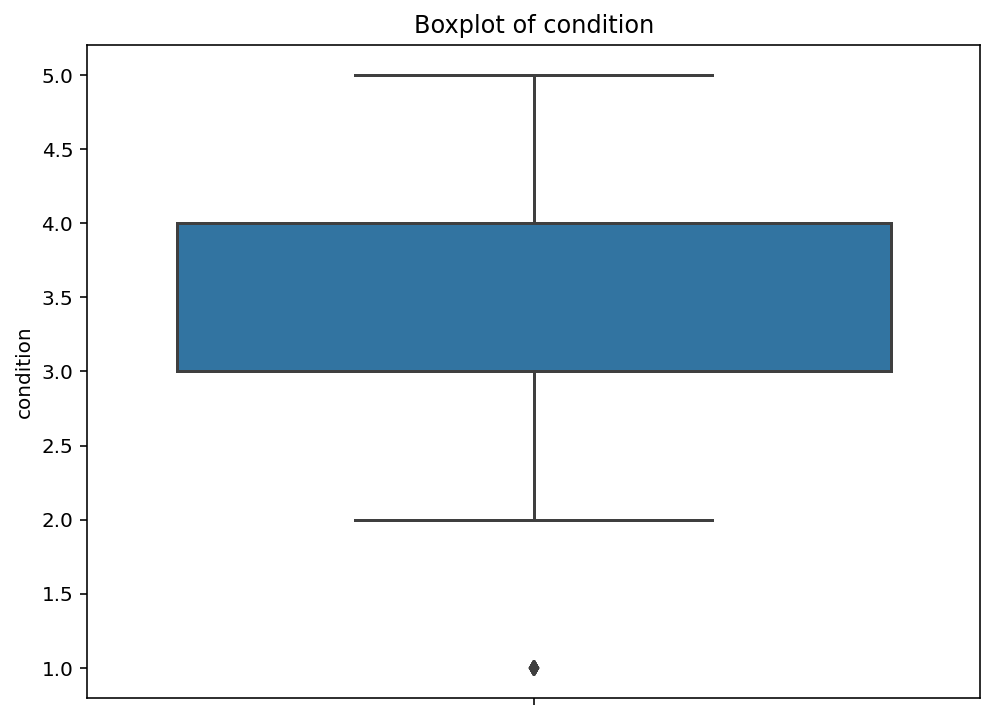

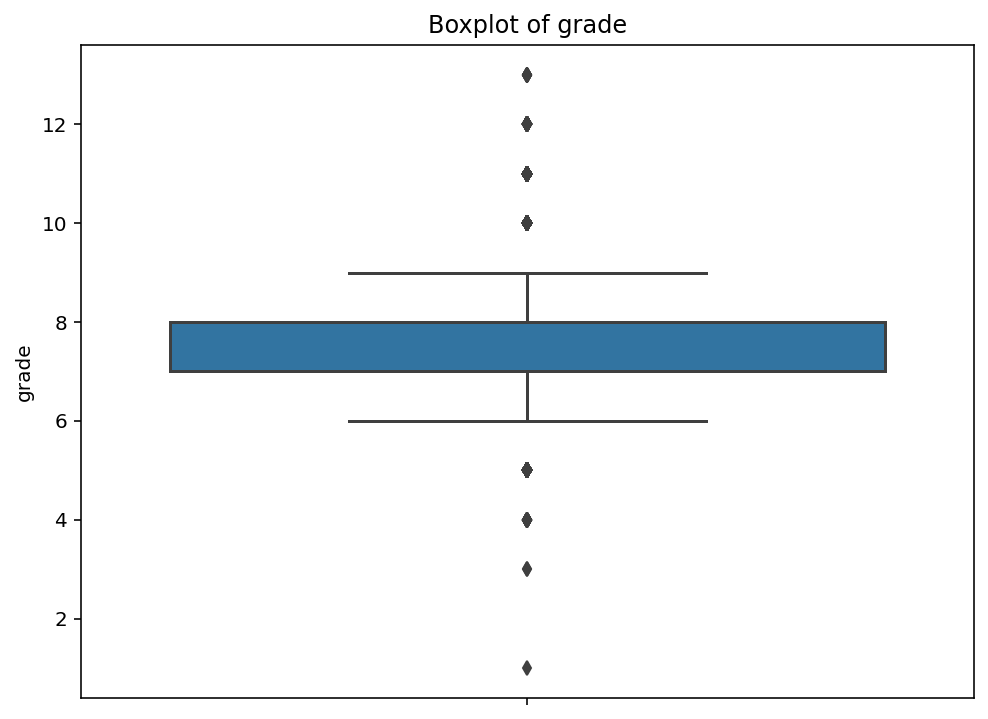

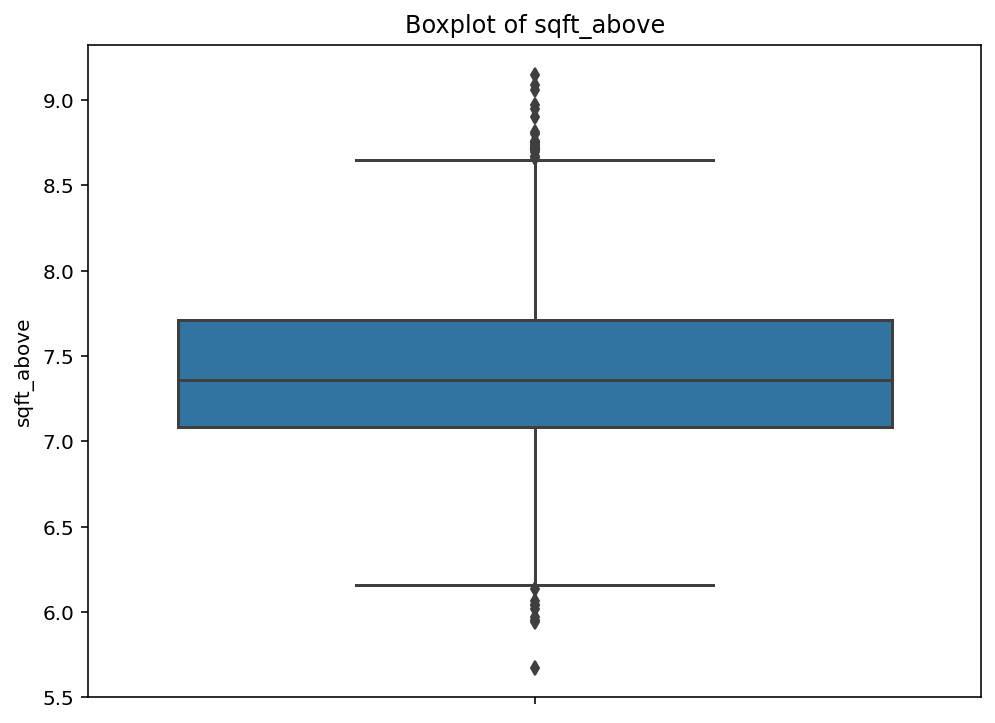

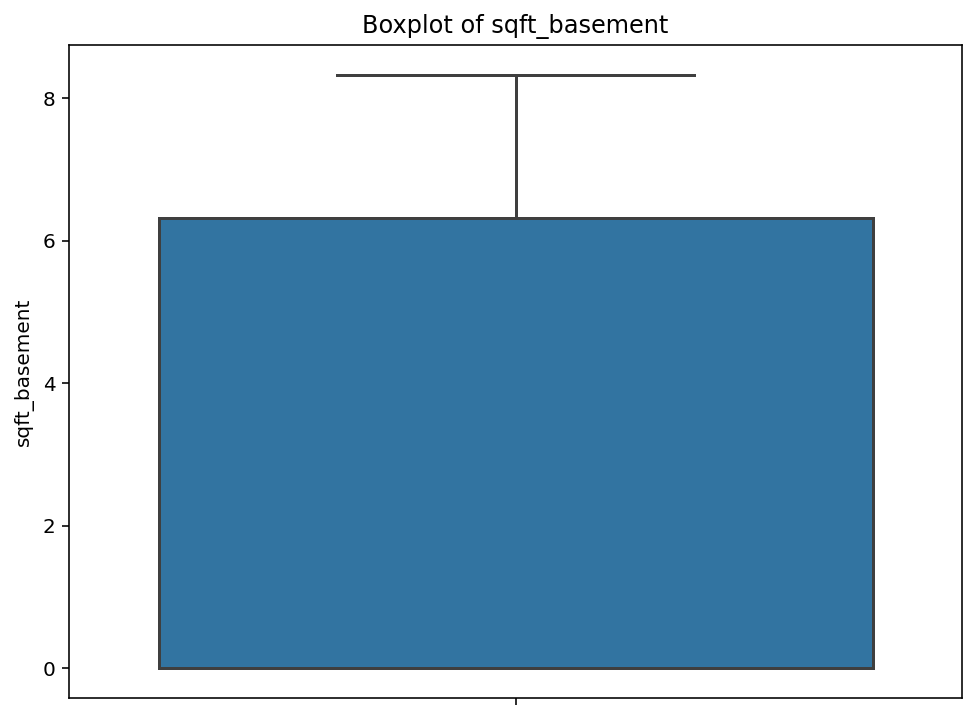

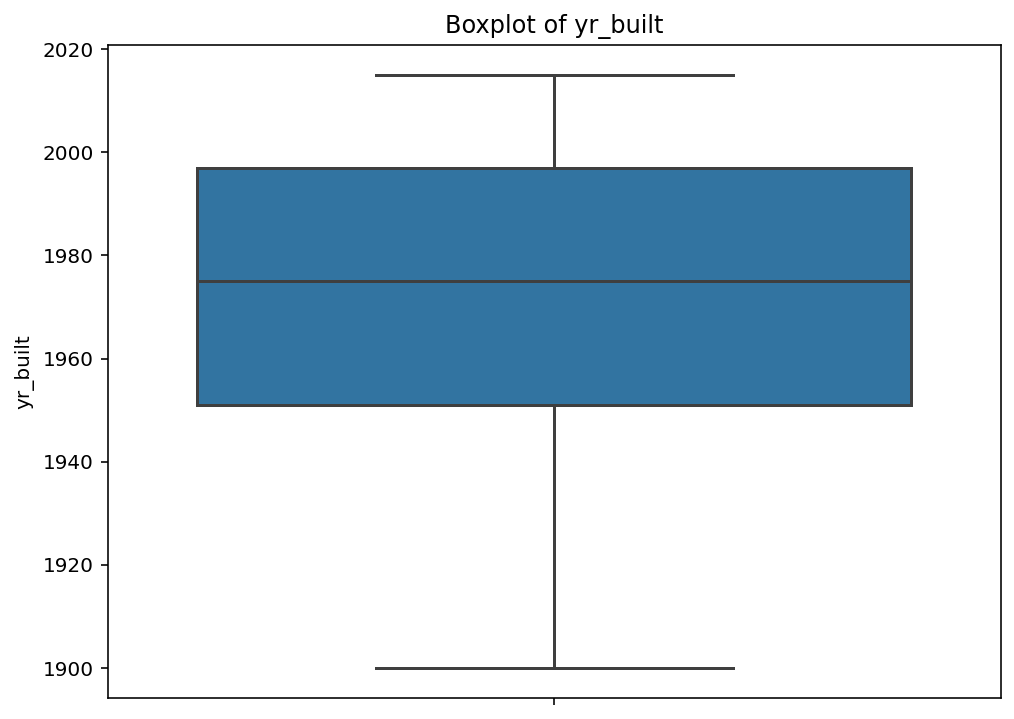

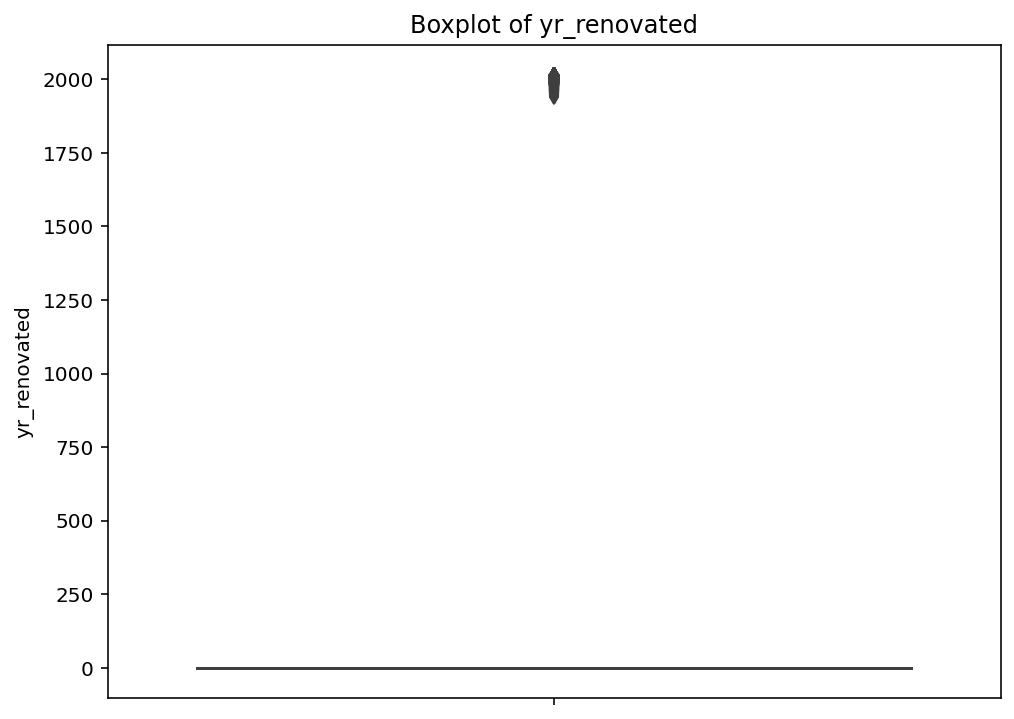

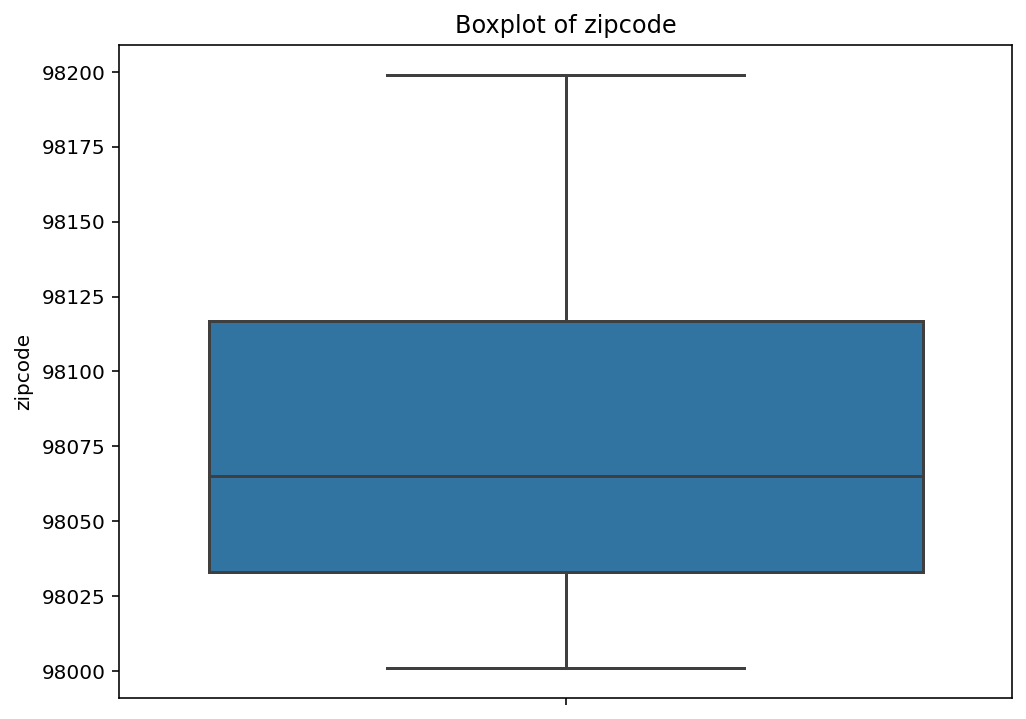

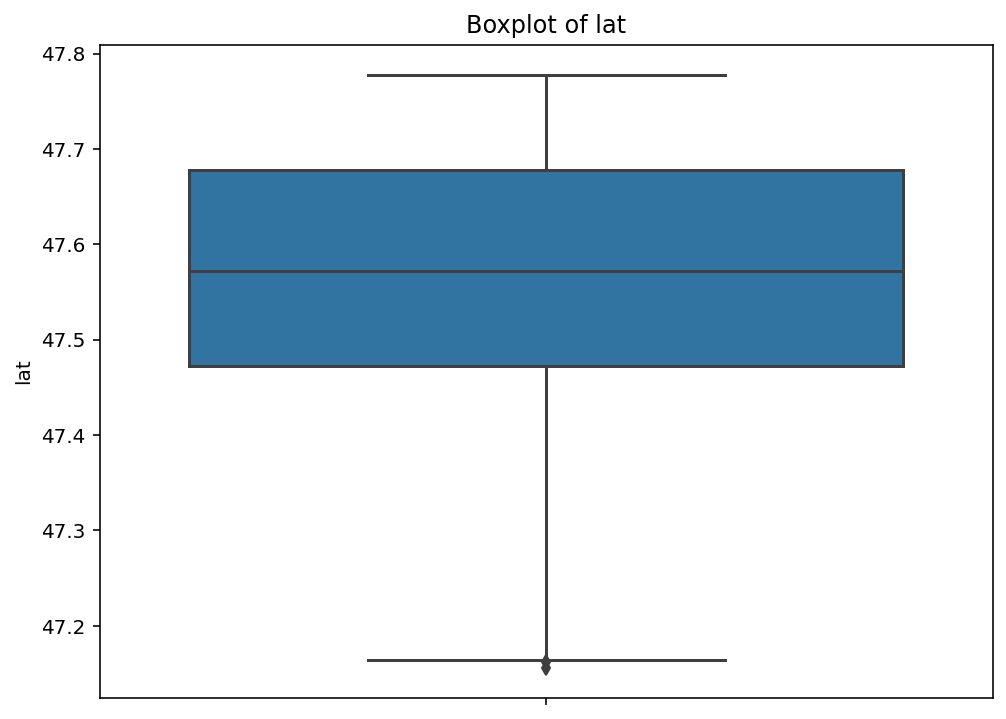

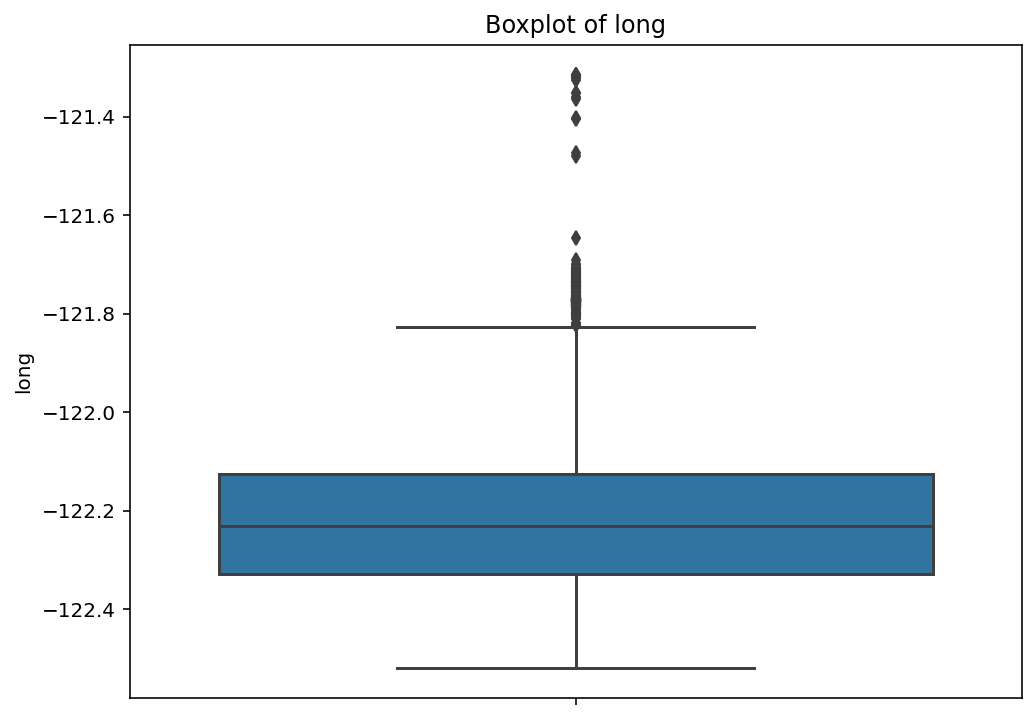

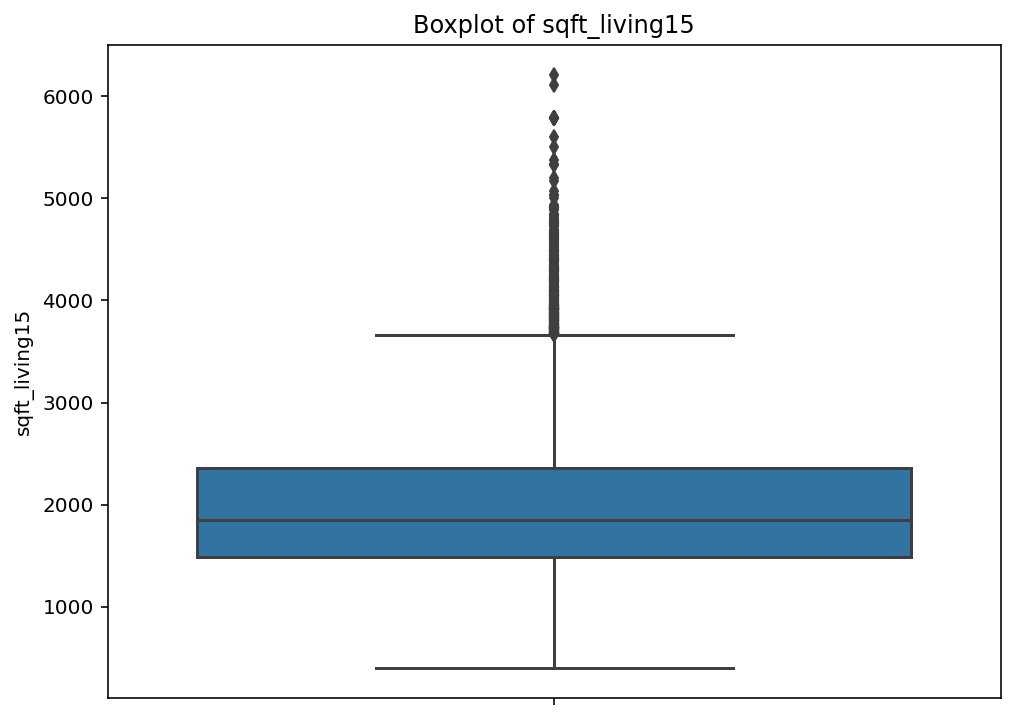

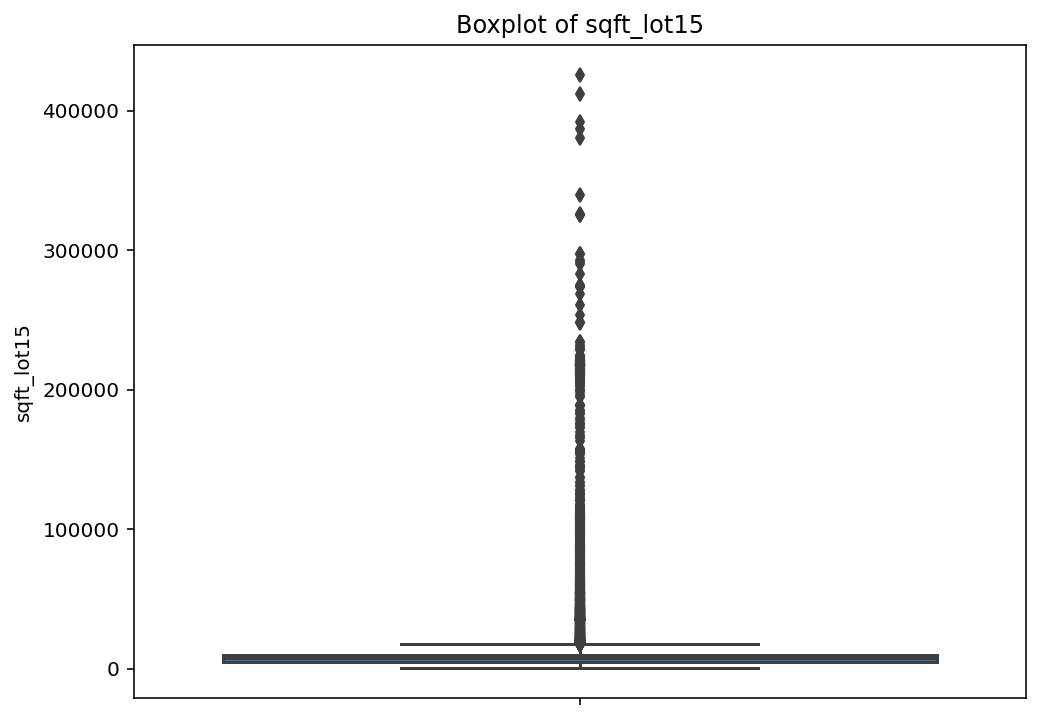

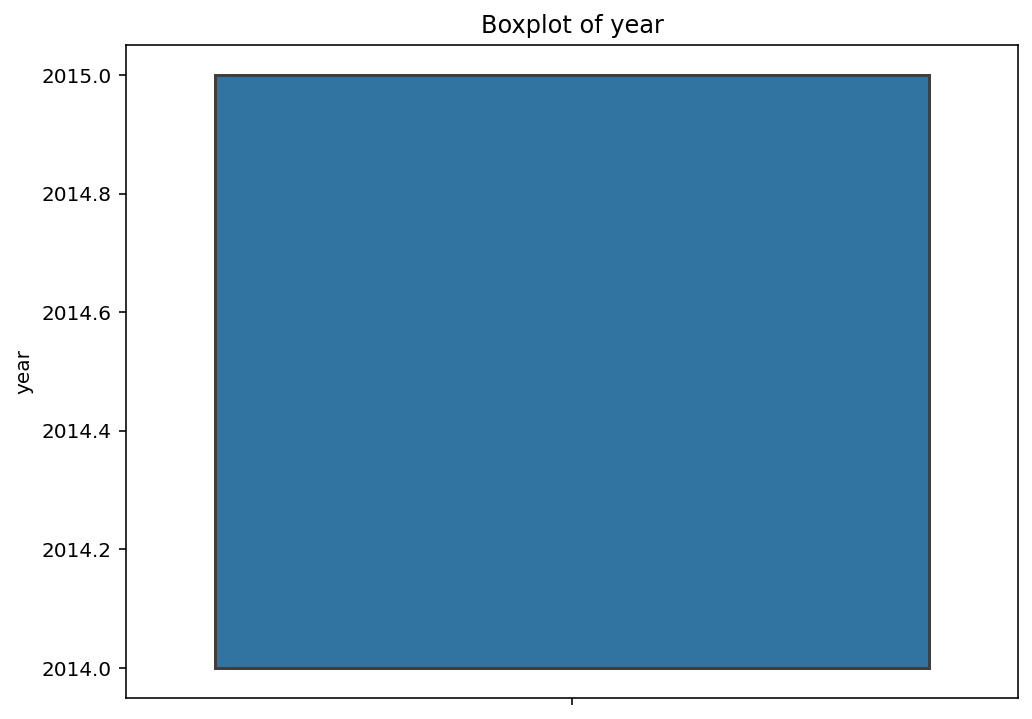

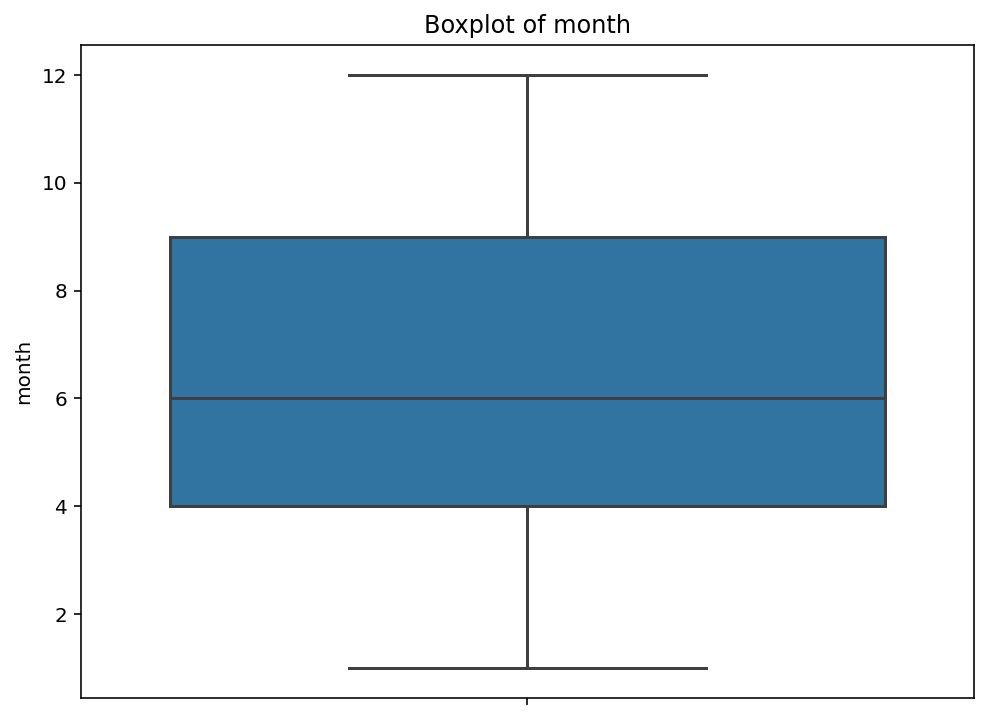

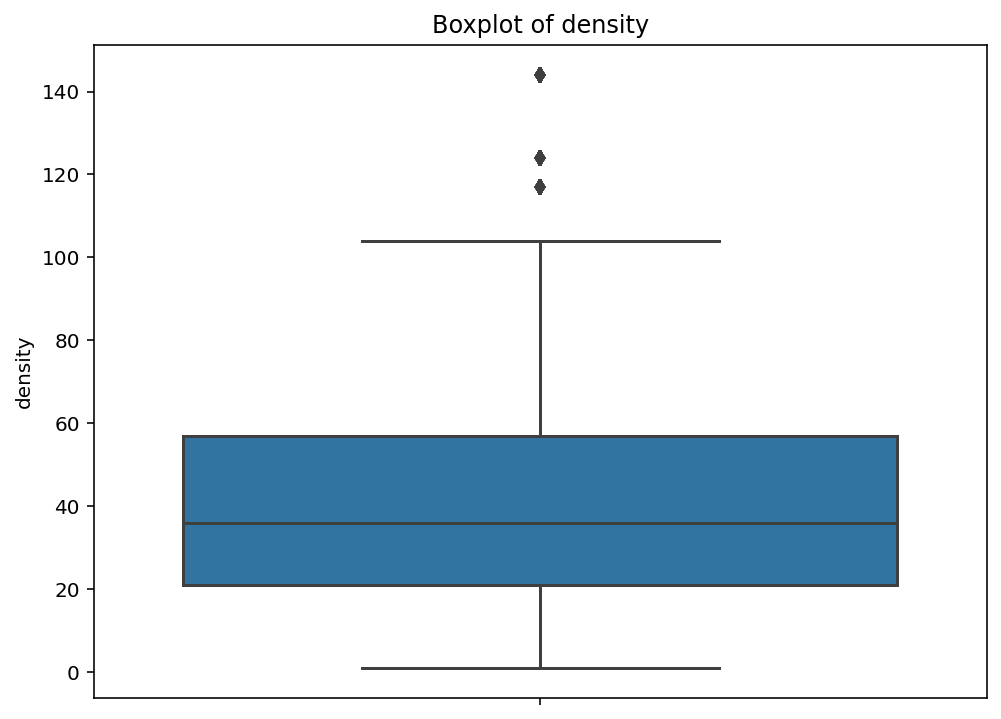

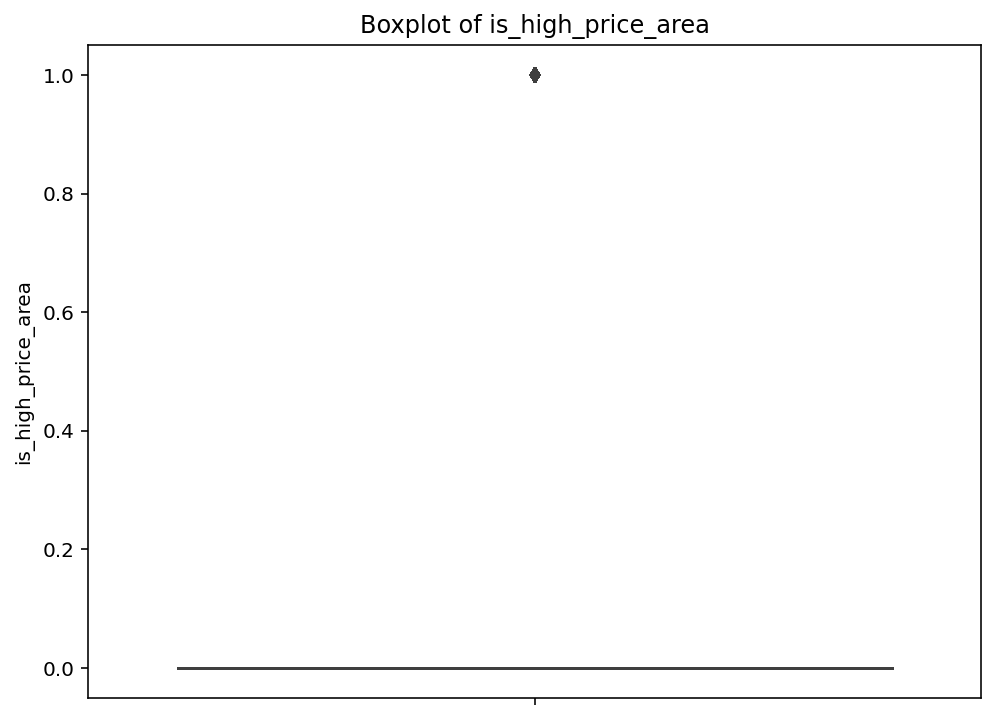

In [391]:
for col in train.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=train, y=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

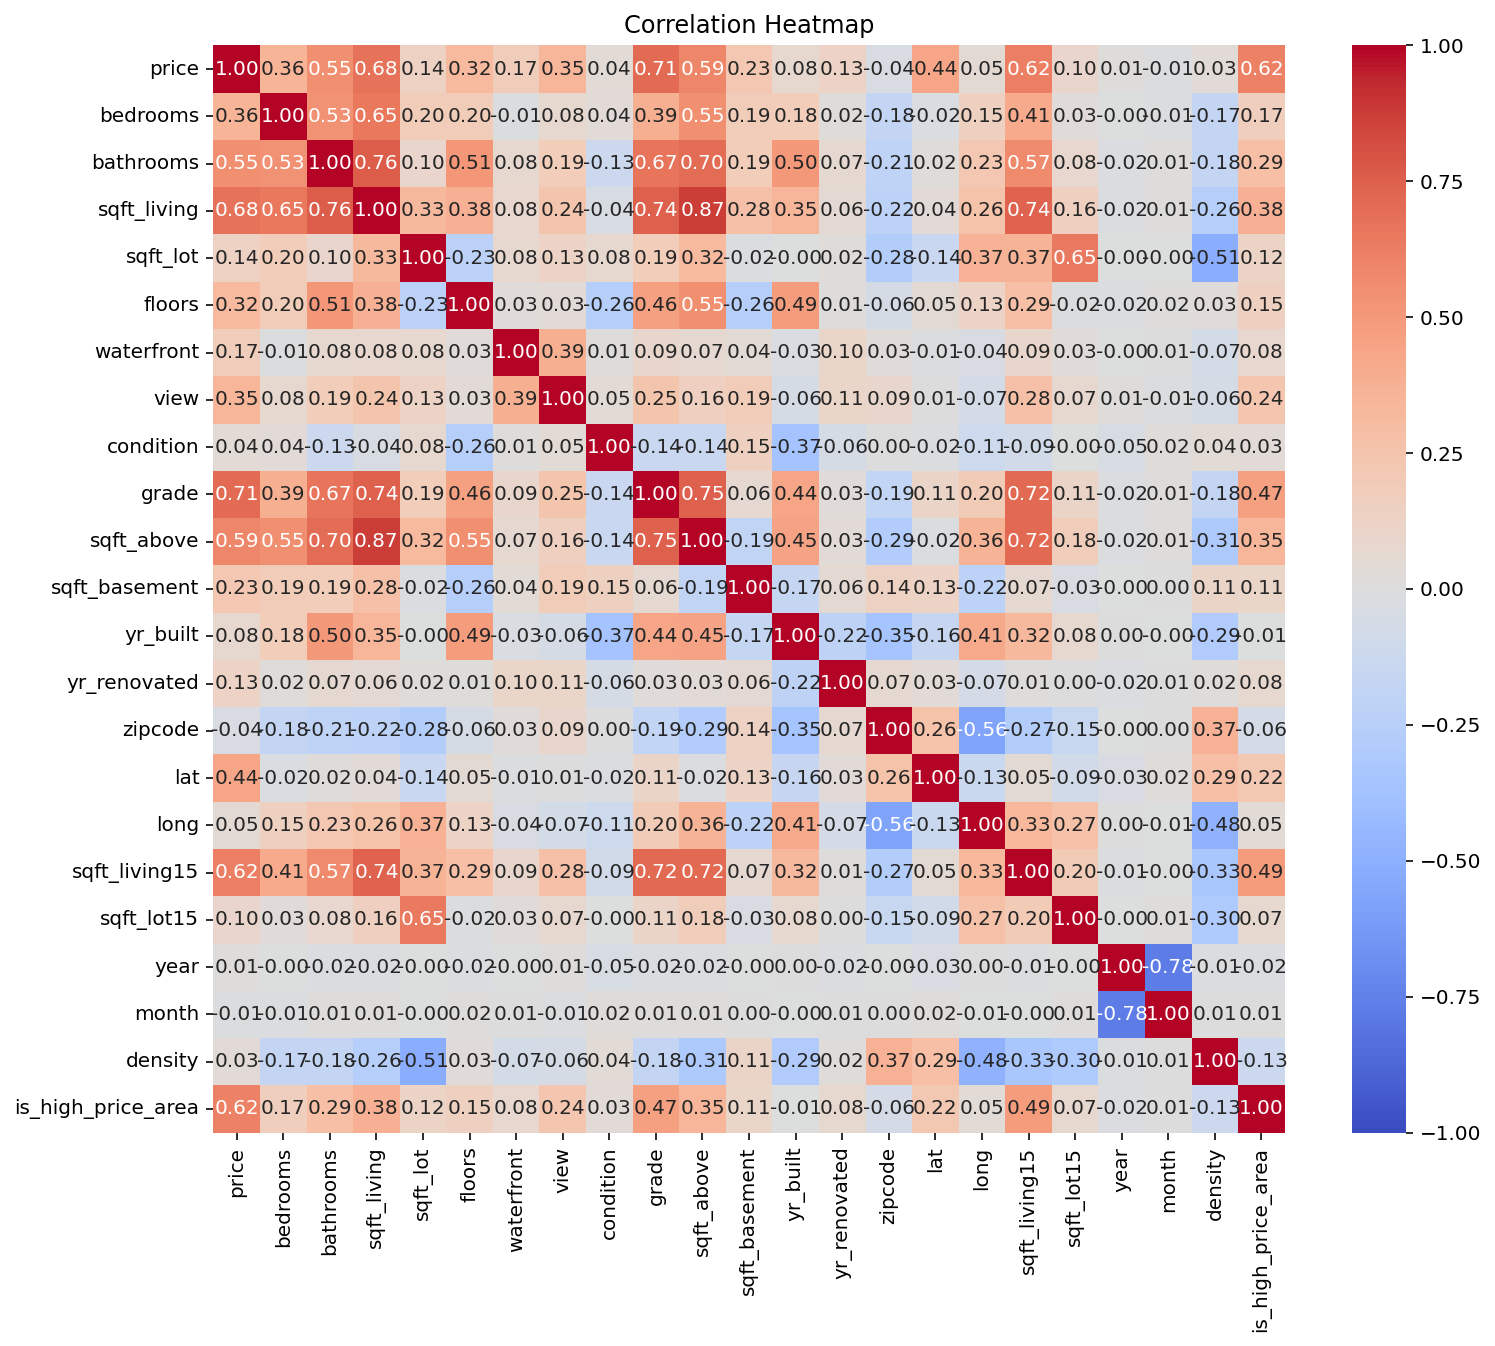

In [392]:
# 상관 행렬 계산
corr_matrix = train.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [393]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 다중공선성 검증
vif_data = pd.DataFrame()
vif_data["feature"] = train.columns  # 컬럼 이름을 그대로 사용

# 분산팽창
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

print(vif_data)

               feature           VIF
0                price  3.338479e+03
1             bedrooms  9.435517e+01
2            bathrooms  2.887171e+01
3          sqft_living  8.675438e+03
4             sqft_lot  3.278544e+02
5               floors  2.255389e+01
6           waterfront  1.231543e+00
7                 view  1.570415e+00
8            condition  3.702863e+01
9                grade  1.698431e+02
10          sqft_above  7.939643e+03
11       sqft_basement  1.079093e+01
12            yr_built  1.206568e+04
13        yr_renovated  1.210193e+00
14             zipcode  5.362467e+06
15                 lat  2.114225e+05
16                long  1.474393e+06
17       sqft_living15  2.957026e+01
18          sqft_lot15  2.419776e+00
19                year  4.484009e+06
20               month  6.324060e+00
21             density  6.041092e+00
22  is_high_price_area  2.318410e+00


* 여기서 다중공선성의 문제가 촉발된다. date를 그대로 넣어두면 무려 수백만의 수치가 기록된다.
* 원-핫 인코딩으로 싹 다 몰아넣자

In [47]:
one_hot_columns = ['is_high_price_area']  
train = pd.get_dummies(train, columns=one_hot_columns)
test = pd.get_dummies(test, columns=one_hot_columns)

In [394]:
one_hot_columns = ['year', 'month', 'floors','waterfront']  
train = pd.get_dummies(train, columns=one_hot_columns)

one_hot_columns = ['year', 'month', 'floors','waterfront']  
test = pd.get_dummies(test, columns=one_hot_columns)

* 난 정말로 유의미한 해석을 위해 아래와 같은 변수를 삭제하고 싶었다. rmse만 크게 나오지 않았더라면 그랬을 것이다.

In [127]:
# drop_col = ['year','long','lat','zipcode','yr_built','real_living']
# train = train.drop(columns=drop_col)
# test = test.drop(columns=drop_col)

In [48]:
train.shape

(15035, 23)

In [49]:
test.shape

(6468, 22)

* 다중공선성이 대충 해소가 된 모습이다. 

In [397]:
# 다중공선성 검증
vif_data = pd.DataFrame()
vif_data["feature"] = train.columns  

# 분산팽창
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

print(vif_data)

               feature        VIF
0                price   5.502560
1             bedrooms   1.963651
2            bathrooms   3.380644
3          sqft_living  27.715477
4             sqft_lot   3.296111
5                 view   1.446027
6            condition   1.304612
7                grade   3.948520
8           sqft_above  27.516839
9        sqft_basement   6.683428
10            yr_built   3.153454
11        yr_renovated   1.171031
12             zipcode   1.693927
13                 lat   1.806930
14                long   2.004294
15       sqft_living15   3.213236
16          sqft_lot15   1.956315
17             density   1.913660
18  is_high_price_area   1.859129
19           year_2014        inf
20           year_2015        inf
21             month_1        inf
22             month_2        inf
23             month_3        inf
24             month_4        inf
25             month_5        inf
26             month_6        inf
27             month_7        inf
28            

In [398]:
train.isnull().sum()

price                 0
bedrooms              0
bathrooms             0
sqft_living           0
sqft_lot              0
view                  0
condition             0
grade                 0
sqft_above            0
sqft_basement         0
yr_built              0
yr_renovated          0
zipcode               0
lat                   0
long                  0
sqft_living15         0
sqft_lot15            0
density               0
is_high_price_area    0
year_2014             0
year_2015             0
month_1               0
month_2               0
month_3               0
month_4               0
month_5               0
month_6               0
month_7               0
month_8               0
month_9               0
month_10              0
month_11              0
month_12              0
floors_1.0            0
floors_1.5            0
floors_2.0            0
floors_2.5            0
floors_3.0            0
floors_3.5            0
waterfront_0          0
waterfront_1          0
dtype: int64

In [399]:
test.isnull().sum()

bedrooms              0
bathrooms             0
sqft_living           0
sqft_lot              0
view                  0
condition             0
grade                 0
sqft_above            0
sqft_basement         0
yr_built              0
yr_renovated          0
zipcode               0
lat                   0
long                  0
sqft_living15         0
sqft_lot15            0
density               0
is_high_price_area    0
year_2014             0
year_2015             0
month_1               0
month_2               0
month_3               0
month_4               0
month_5               0
month_6               0
month_7               0
month_8               0
month_9               0
month_10              0
month_11              0
month_12              0
floors_1.0            0
floors_1.5            0
floors_2.0            0
floors_2.5            0
floors_3.0            0
floors_3.5            0
waterfront_0          0
waterfront_1          0
dtype: int64

In [50]:
x_train = train.drop(columns=['price']) 
y_train = train['price']
x_test = test 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

In [403]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)


models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},{'model':rdforest, 'name':'rdforest'}]

# RMSE 스코어 설정
rmse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE를 계산하도록 설정

# 교차 검증 스코어 계산 함수
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019)
    for m in models:
        # RMSE 기준으로 cross_val_score 계산
        cv_score = cross_val_score(m['model'], x_train, y_train, cv=kfold, scoring=rmse_scorer)
        print("Model {} CV RMSE : {:.4f}".format(m['name'], np.mean(cv_score)))

# 함수 호출
get_cv_score(models)

Model GradientBoosting CV RMSE : 0.1803
Model XGBoost CV RMSE : 0.1659
Model LightGBM CV RMSE : 0.1623
Model rdforest CV RMSE : 0.1767


In [51]:
param_grid = {
    'n_estimators': [50, 100,150,200],
    'max_depth': [10, 30, 50,70,90],
}

In [52]:
model = LGBMRegressor(random_state=random_state)

In [53]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [10, 30, 50, 70, 90],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [54]:
grid_model.cv_results_

params = grid_model.cv_results_['params']
params

score = grid_model.cv_results_['mean_test_score']
score

array([-0.02910087, -0.02652088, -0.02591963, -0.02572606, -0.02905961,
       -0.02665201, -0.02613818, -0.02587651, -0.02905961, -0.02665201,
       -0.02613818, -0.02587651, -0.02905961, -0.02665201, -0.02613818,
       -0.02587651, -0.02905961, -0.02665201, -0.02613818, -0.02587651])

In [55]:
results = pd.DataFrame(params)
results['score'] = score
results['RMSE'] = np.sqrt(-1 * results['score'])

# RMSE를 RMSLE로 열 이름 변경
results = results.rename(columns={'RMSE': 'RMSLE'})

# 결과 확인
results

max_depth  n_estimators     score     RMSLE
0          10            50 -0.029101  0.170590
1          10           100 -0.026521  0.162852
2          10           150 -0.025920  0.160996
3          10           200 -0.025726  0.160393
4          30            50 -0.029060  0.170469
5          30           100 -0.026652  0.163254
6          30           150 -0.026138  0.161673
7          30           200 -0.025877  0.160862
8          50            50 -0.029060  0.170469
9          50           100 -0.026652  0.163254
10         50           150 -0.026138  0.161673
11         50           200 -0.025877  0.160862
12         70            50 -0.029060  0.170469
13         70           100 -0.026652  0.163254
14         70           150 -0.026138  0.161673
15         70           200 -0.025877  0.160862
16         90            50 -0.029060  0.170469
17         90           100 -0.026652  0.163254
18         90           150 -0.026138  0.161673
19         90           200 -0.025877  0.160862

In [58]:
# 결과 확인
results
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(x_train, y_train)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 665709.49041245,  676591.48000154, 1925088.2460895 , ...,
       1818781.52991863,  939194.87482686,  965789.24397831])

In [59]:
sub = pd.DataFrame(data={'id': sub_id, 'price': prediction})
sub.to_csv('submission11.csv', index=False)

* 실질적으로 train-검증에서는 성능이 향상되었으나, 캐글 제출에서는 수배 차이가 나는 값으로 튀어나간다. 
* 과적합? 은 아닌거 같다. 파라미터를 낮춰도, 그렇고 내가 설정한 변수가 의미있는 변수가 아니었나?

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [142]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [143]:
y_pred = AveragingBlending(models, x, y, sub)

In [144]:
y_pred.shape

(6468,)

In [145]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [146]:
sub.to_csv('submission1.csv', index=False)